In [1]:
import os
import cell_lineage_tracking as lineage
import gnn_ben_haim as bh_track
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
torch.set_default_dtype(torch.float32)
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
import torch.nn as nn
from torch.utils.data import Subset
import lineage_detection

In [2]:
cells_filename = '/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data.pkl'
all_cells_df = pd.read_pickle(cells_filename)

In [3]:
all_cells_df['experiment_name'].unique()

array(['DUMM_giTG62_Glucose_012925'], dtype=object)

In [4]:
strain_exp_dict = {# need araB gitg61/CL08 lineage tracing CL008_giTG068_072925 pos 0-10 is CL08 # don't see fluor signal
                  # need alkA gitg63 lineage tracing potentially DUMM_giTG63_giTG67_Glucose_121724_1 pos 5, 'DUMM_giTG068_063_061725' look at pos 1-8, had pos 0 but bad for lineage
                  # need murQ gitg67 lineage tracing potenitally DUMM_giTG068_067_061825 or DUMM_giTG63_giTG67_Glucose_121724_1 pos 6-9

                  'chpS': ['DUMM_giTG62_Glucose_012925'],  #need lineage tracing, Nora working on it
                  'baeS':['DUMM_giTG66_Glucose_012325'],  # need to find new exp, lineage tracing is bad on this one
                  'lacZ':['DUMM_giTG059_noKan_Glucose_031125'],
                  'gfcE': ['DUMM_giTG064_Glucose_022625'],
                  'gldA': ['DUMM_giTG69_Glucose_013025'],
                  #'murQ': [' DUMM_giTG63_giTG67_Glucose_121724_1'],
                  'alkA': ['DUMM_giTG068_063_061725_v2','DUMM_giTG63_giTG67_Glucose_121724_1_v2'],
                  'mazF': ['DUMM_giTG059_060_061125'], # constitutive
                  'hupA':['DUMM_giTG068_052925', 'DUMM_giTG068_063_061725'] # constitutive
                  }

In [5]:
df_all = pd.DataFrame()
for gene, exps in strain_exp_dict.items():
    for exp_view in exps:
        print(exp_view)
        all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{exp_view}.pkl'
        all_cells_pd = pd.read_pickle(all_cells_filename)
        all_cells_pd['gene'] = gene
        if df_all.empty:
            df_all = all_cells_pd
        else:
            df_all = pd.concat([df_all, all_cells_pd], ignore_index=True)

DUMM_giTG62_Glucose_012925
DUMM_giTG66_Glucose_012325
DUMM_giTG059_noKan_Glucose_031125
DUMM_giTG064_Glucose_022625
DUMM_giTG69_Glucose_013025
DUMM_giTG068_063_061725_v2
DUMM_giTG63_giTG67_Glucose_121724_1_v2
DUMM_giTG059_060_061125
DUMM_giTG068_052925
DUMM_giTG068_063_061725


In [6]:
df_test = df_all[(df_all['experiment_name'] == 'DUMM_giTG62_Glucose_012925') & 
    (df_all['FOV'] == '005') & 
    (df_all['trench_id'] == '445') &
    ~df_all['ground_truth_lineage'].isna()]

In [7]:
def calculate_normalized_proximity_threshold_from_gt(df_cells,
                                                    time_frame_col='time_frame',
                                                    y_col='centroid_y',
                                                    lineage_col='ground_truth_lineage'):
    """
    Calculates a suggested normalized proximity threshold based on ground truth lineage.
    This provides a highly accurate estimate of typical cell movement.

    Args:
        df_cells (pd.DataFrame): DataFrame containing cell data, including ground truth lineage.
        time_frame_col (str): The column name for time frames.
        y_col (str): The column name for the Y coordinate.
        lineage_col (str): The column name for ground truth lineage labels.

    Returns:
        float: A suggested value for proximity_threshold_1d.
    """
    if df_cells.empty or lineage_col not in df_cells.columns:
        print("DataFrame is empty or missing 'ground_truth_lineage' column.")
        return None

    # Calculate the total range of the centroid_y data for normalization
    y_min = df_cells[y_col].min()
    y_max = df_cells[y_col].max()
    y_range = y_max - y_min

    if y_range == 0:
        print("Y-range is zero. All cells are on the same y-coordinate.")
        return 0.0

    normalized_distances = []

    # Sort by time frame to process sequentially
    df_sorted = df_cells.sort_values(by=time_frame_col)
    
    # Iterate through each unique lineage
    for lineage_id, df_lineage in df_sorted.groupby(lineage_col):
        # We need at least two time points to calculate a distance
        if len(df_lineage) < 2:
            continue
            
        # Get the y-coordinates and time frames for this lineage
        y_coords = df_lineage[y_col].values
        time_frames = df_lineage[time_frame_col].values
        
        # Calculate the distance between consecutive time frames for this lineage
        for i in range(len(y_coords) - 1):
            # Check if the time frames are consecutive
            if time_frames[i+1] == time_frames[i] + 1:
                dist_px = np.abs(y_coords[i+1] - y_coords[i])
                normalized_dist = dist_px / y_range
                normalized_distances.append(normalized_dist)

    if not normalized_distances:
        print("No consecutive cell movements found for any lineage.")
        return None

    # Add a buffer (e.g., 20%) to the average to account for measurement noise
    avg_normalized_distance = np.mean(normalized_distances)
    suggested_threshold = avg_normalized_distance * 1.2
    
    print(f"Average normalized distance of cells with same lineage: {avg_normalized_distance:.4f}")
    print(f"Suggested proximity_threshold_1d (with 20% buffer): {suggested_threshold:.4f}")
    
    return suggested_threshold

In [8]:
calculate_normalized_proximity_threshold_from_gt(df_test,
                                                    time_frame_col='time_frame',
                                                    y_col='centroid_y',
                                                    lineage_col='ground_truth_lineage')

Average normalized distance of cells with same lineage: 0.0173
Suggested proximity_threshold_1d (with 20% buffer): 0.0208


np.float64(0.020798806231489216)

In [9]:
df_all['node_id'] = df_all.index

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [11]:
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']
for col in node_feature_cols:
    df_all[col] = df_all[col].astype(np.float32);   

In [12]:
# Access the node features from the single train_df DataFrame.
all_train_node_features_df = df_all[node_feature_cols].values.astype(np.float32)

# Initialize and fit the scaler on the training data.
scaler = StandardScaler()
scaler.fit(all_train_node_features_df)
print("Scaler fitted on training data.")

# Create an instance of the transform with the fitted scaler.
transform = bh_track.StandardScalerTransform(scaler)

dataset = bh_track.CellTrackingDataset_real_data(root='./processed_data_bh/full_dataset',
                                   df_cells=df_all,
                                   node_feature_cols=node_feature_cols,
                                   device=device,
                                   pre_transform=transform)

batch_size = 32
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Number of test graphs: {len(dataset)}")

Scaler fitted on training data.
Starting data processing for processed_data_bh/full_dataset...


Processing...


Finished processing. Created 50 PyG Data objects.
Processed data saved to processed_data_bh/full_dataset/processed/cell_tracking_fovs.pt
Number of test graphs: 1


Done!


In [13]:
num_node_features = len(node_feature_cols)
initial_edge_feature_dim = len(node_feature_cols) + 1
hidden_channels = 128 # balance between expressiveness and compute

model = bh_track.LineageLinkPredictionGNN(in_channels=num_node_features,
    initial_edge_channels=initial_edge_feature_dim, 
    hidden_channels=128,
    num_blocks=2).to(device)
model.load_state_dict(torch.load('best_link_prediction_model.pt'))
print("Loaded best model for final test evaluation.")

lineage_predictions_df = bh_track.predict_cell_linkages(model,
                                                       test_loader,
                                                       device)

Loaded best model for final test evaluation.
predict_cell_linkages: Prediction complete. Returning results.


/Users/noravivancogonzalez/code/Image_analysis_copy/gnn_ben_haim.py:317: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  current_predicted_edge_indices_global = torch.tensor(


In [14]:
df_consolidated_lineages =  lineage_detection.process_all_fovs(lineage_predictions_df, df_all, prob_threshold=0.8)

Column 'ground_truth_lineage' found. Including it in node attributes.
--- Processing FOV 1/48: DUMM_giTG62_Glucose_012925, 005, 445 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 279 nodes and 317 edges.

All cycles have been removed.
Final graph has 279 nodes and 317 edges.
Successfully generated 317 lineage rows.
--- Processing FOV 2/48: DUMM_giTG62_Glucose_012925, 005, 900 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 10 nodes and 9 edges.

All cycles have been removed.
Final graph has 10 nodes and 9 edges.
Successfully generated 9 lineage rows.
--- Processing FOV 3/48: DUMM_giTG62_Glucose_012925, 005, 1128 ---
--- Adding nodes with all experimental data... ---
--- Building initial graph with edges... ---
Initial graph has 120 nodes and 115 edges.

All cycles have been removed.
Final graph has 120 nodes and 115 edges.
Successfully generated 1

In [15]:
df_for_kymograph_plot = lineage_detection.consolidate_lineages_to_node_df(df_consolidated_lineages, df_all)

--- Consolidating lineage data to a node-centric format... ---
--- Consolidation complete. Final DataFrame is ready for plotting. ---


In [16]:
import matplotlib.colors as mcolors
colors = [(0, 0, 0), (1, 1, 0)]  # Black -> Yellow
black_to_yellow = mcolors.LinearSegmentedColormap.from_list('black_to_yellow', colors)

def plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id', cell_id_to_color=None, highlight_color='red'):
    fig, ax = plt.subplots(2, 1, figsize=(40, 10))

    kymograph_shape = phase_kymograph.shape
    combined_mask = _create_combined_mask(full_region_df, kymograph_shape)
    
    masked_phase_kymograph = phase_kymograph * combined_mask
    masked_fluor_kymograph = fluor_kymograph * combined_mask
    
    ax[0].imshow(masked_phase_kymograph, cmap='grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color, highlight_color=highlight_color)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}, cell_id: {cell_id_to_color}')

    ax[1].imshow(masked_fluor_kymograph, cmap= black_to_yellow)
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color, highlight_color=highlight_color)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}, cell_id: {cell_id_to_color}')

    plt.xlabel("Time frames")
    plt.tight_layout()


def _create_combined_mask(full_region_df, kymograph_shape):
    """
    Creates a single binary mask for the entire kymograph, combining all cell masks.
    """
    combined_mask = np.zeros(kymograph_shape, dtype=bool)
    for _, region_props in full_region_df.iterrows():
        # Check if the 'coords' column exists and is not empty
        if 'coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0:
            cell_pixel_coords = np.array(region_props['coords'])
            rows = cell_pixel_coords[:, 0]
            cols = cell_pixel_coords[:, 1]
            combined_mask[rows, cols] = True
    return combined_mask



def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None, cell_id_to_color=None, highlight_color='red'):
    default_cell_contour_color = 'white'
    text_color = 'white'
    text_offset_x = 5
    text_offset_y = 0

    all_contours_segments = []
    all_contour_colors = []
    
    all_text_params = []

    # Case 1: A specific cell is specified, so we'll show an arrow and no contour for it
    if cell_id_to_color is not None:
        for _, region_props in full_region_df.iterrows():
            if not ('coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0):
                continue
            
            cell_pixel_coords = np.array(region_props['coords'])
            is_cell_of_interest = lineage_col and region_props[lineage_col] == cell_id_to_color
            
            y_coord = region_props[y_coord_col]
            x_coord = region_props[x_coord_col]
            
            # Only add arrow and text for the cell of interest
            if is_cell_of_interest:
                top_edge_y = np.min(cell_pixel_coords[:, 0])
                arrow_tip_y = top_edge_y - 2
                arrow_start_y = arrow_tip_y - 15
                arrow_x = x_coord
                
                ax.annotate('', xy=(arrow_x, arrow_tip_y), xytext=(arrow_x, arrow_start_y), 
                            arrowprops=dict(facecolor=highlight_color, edgecolor=highlight_color, shrink=0.05, width=2, headwidth=8, headlength=8))
                
    # Case 2: No specific cell is specified, show colored contours for all cells
    else:
        track_colors = None
        if lineage_col:
            unique_track_ids = full_region_df[lineage_col].dropna().unique()
            colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
            track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

        for _, region_props in full_region_df.iterrows():
            if not ('coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0):
                continue
            
            cell_pixel_coords = np.array(region_props['coords'])
            
            min_row, min_col = np.min(cell_pixel_coords, axis=0)
            max_row, max_col = np.max(cell_pixel_coords, axis=0)
            buffer = 1
            bbox_min_row = max(0, min_row - buffer)
            bbox_min_col = max(0, min_col - buffer)
            bbox_max_row = min(kymograph_shape[0], max_row + buffer)
            bbox_max_col = min(kymograph_shape[1], max_col + buffer)
            temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
            temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)
            relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
            relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
            temp_mask[relative_rows, relative_cols] = 1
            contours = find_contours(temp_mask, level=0.5, fully_connected='high')
            if not contours:
                continue
            
            if lineage_col and track_colors and region_props[lineage_col] in track_colors:
                current_color = track_colors[region_props[lineage_col]]
            else:
                current_color = default_cell_contour_color
            
            for contour in contours:
                global_contour_x = contour[:, 1] + bbox_min_col
                global_contour_y = contour[:, 0] + bbox_min_row
                all_contours_segments.append(np.vstack([global_contour_x, global_contour_y]).T)
                all_contour_colors.append(current_color)

    # Plot the collected data after the loop
    if all_contours_segments:
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=2)
        ax.add_collection(line_collection)
    
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [17]:
unique_fovs = df_for_kymograph_plot[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_22822/4234988162.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(40, 10))


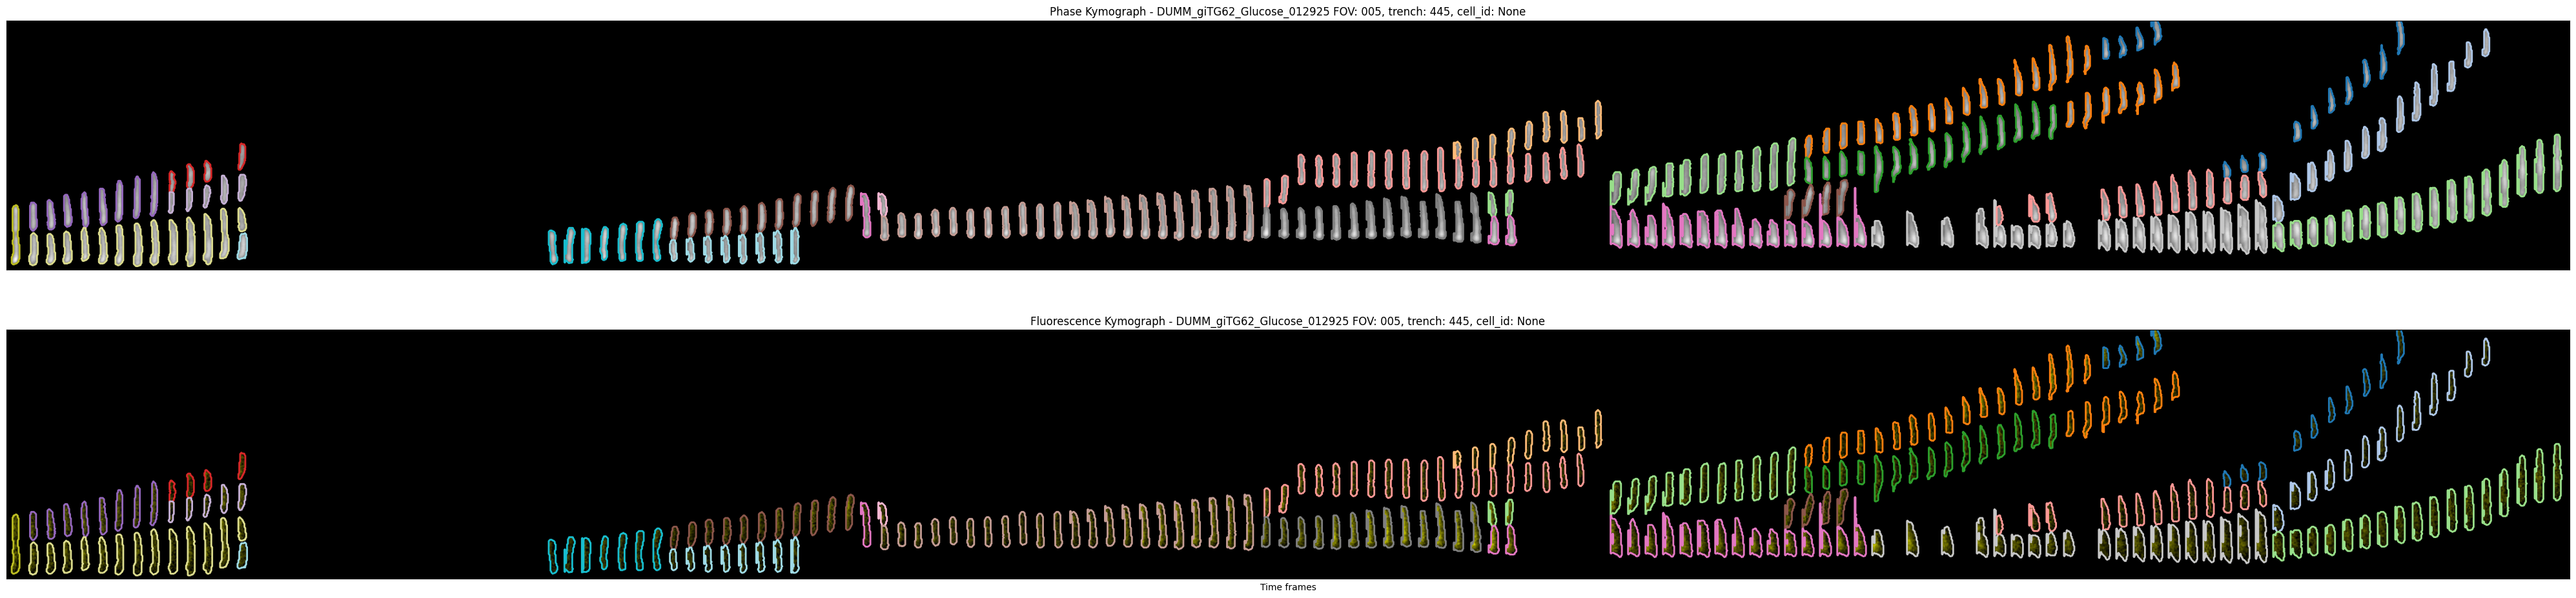

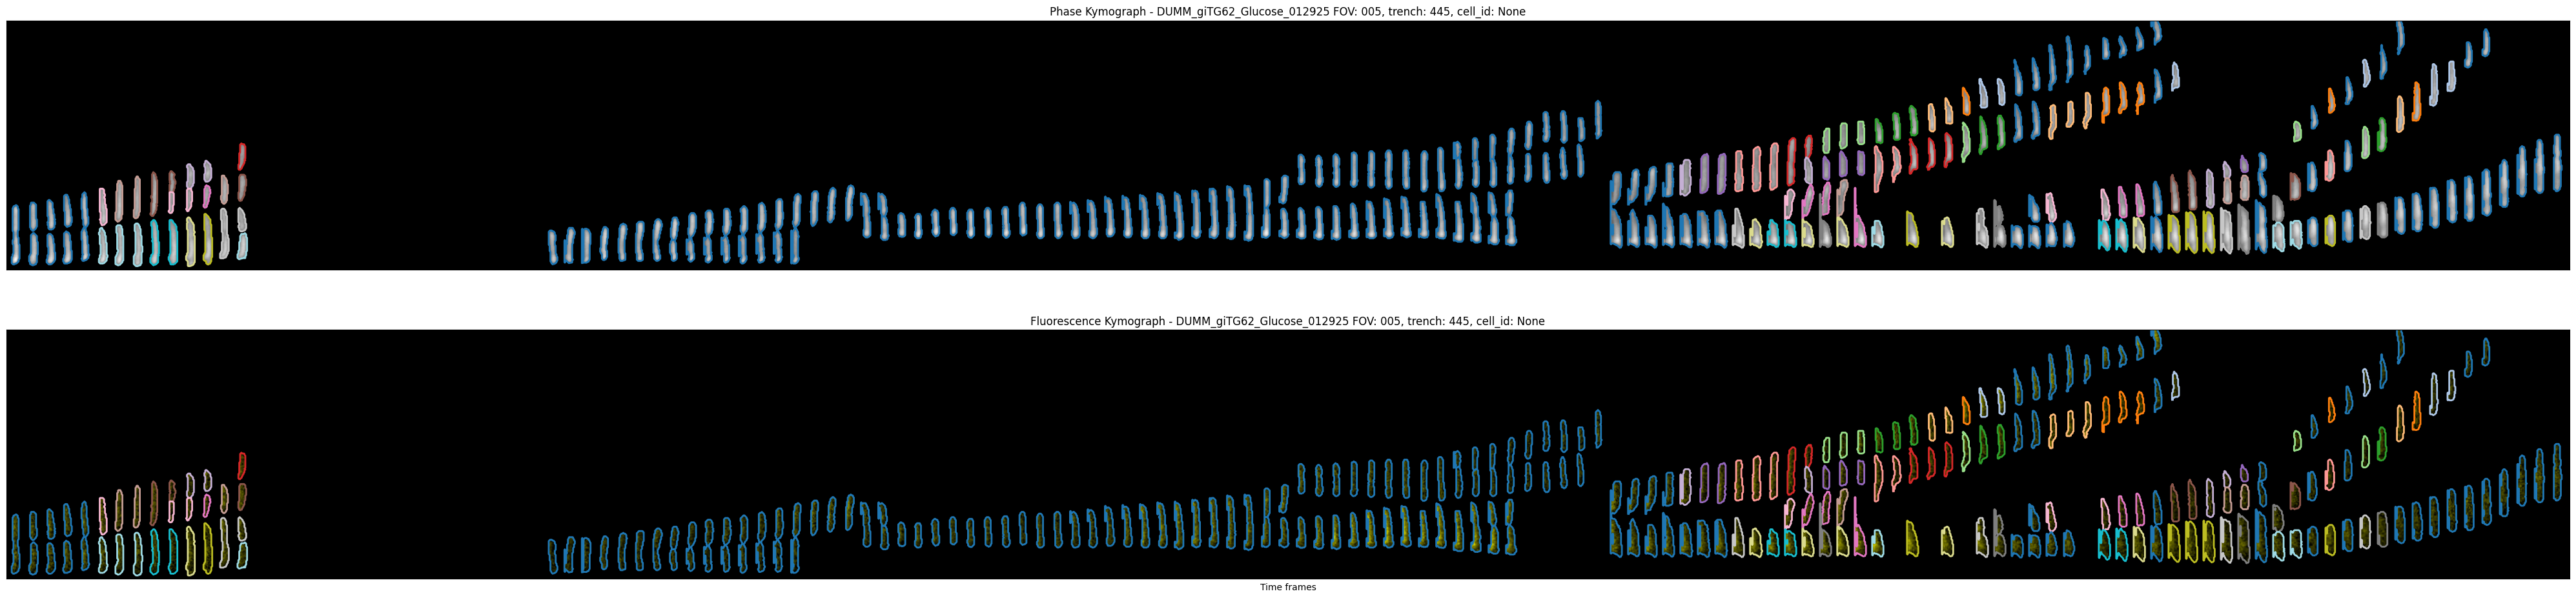

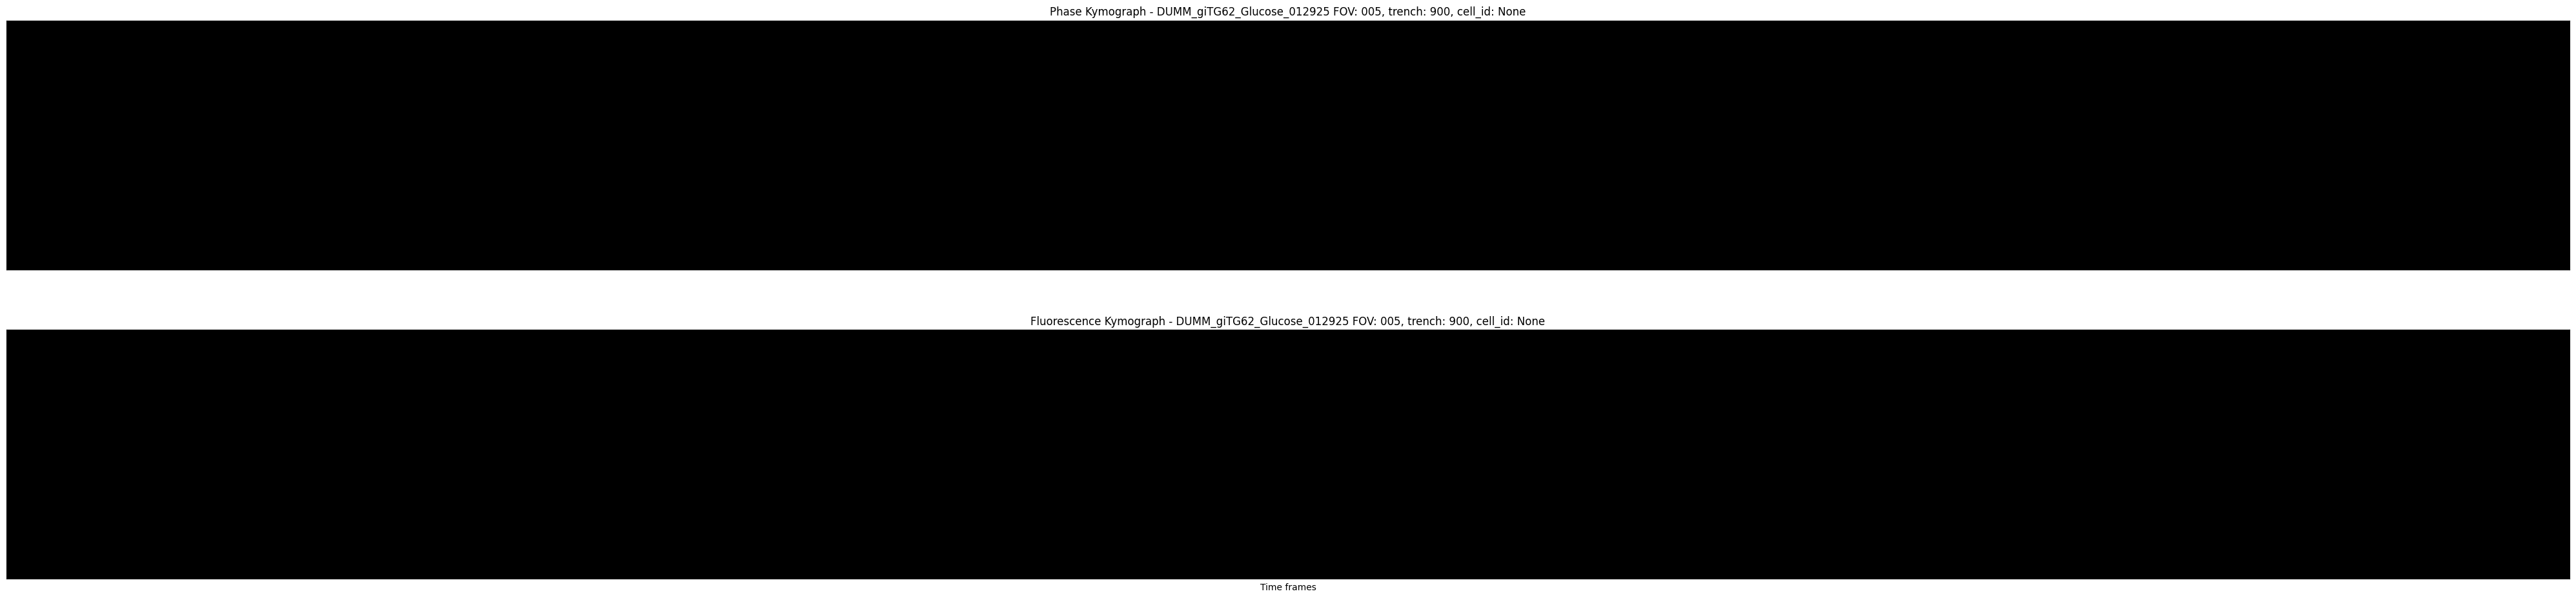

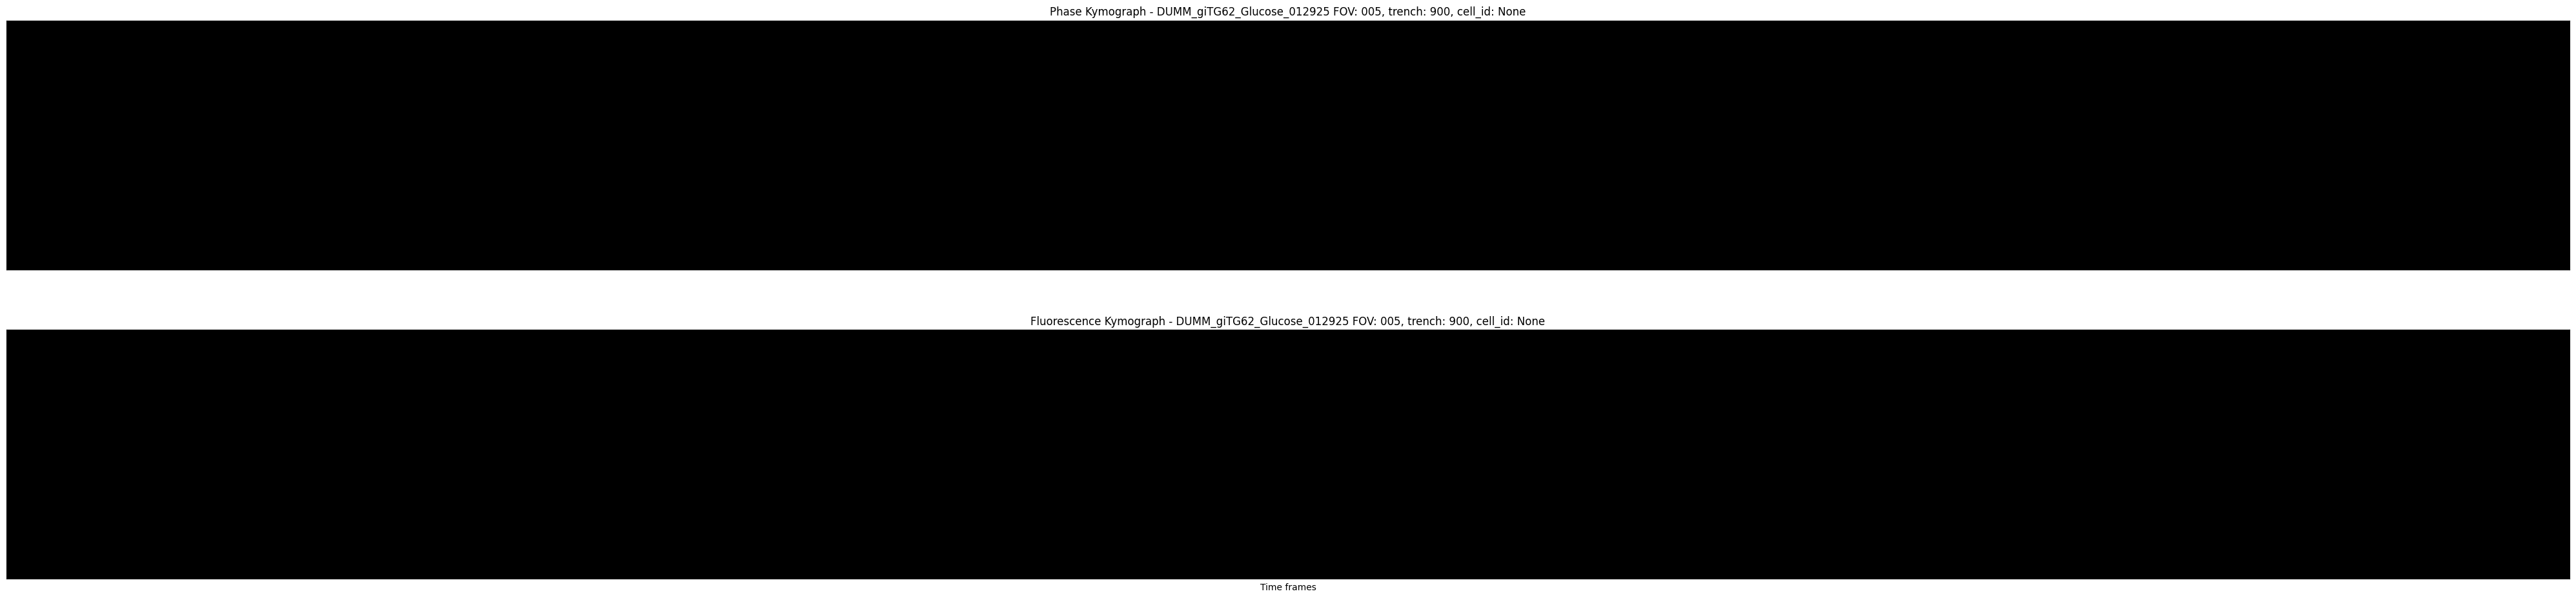

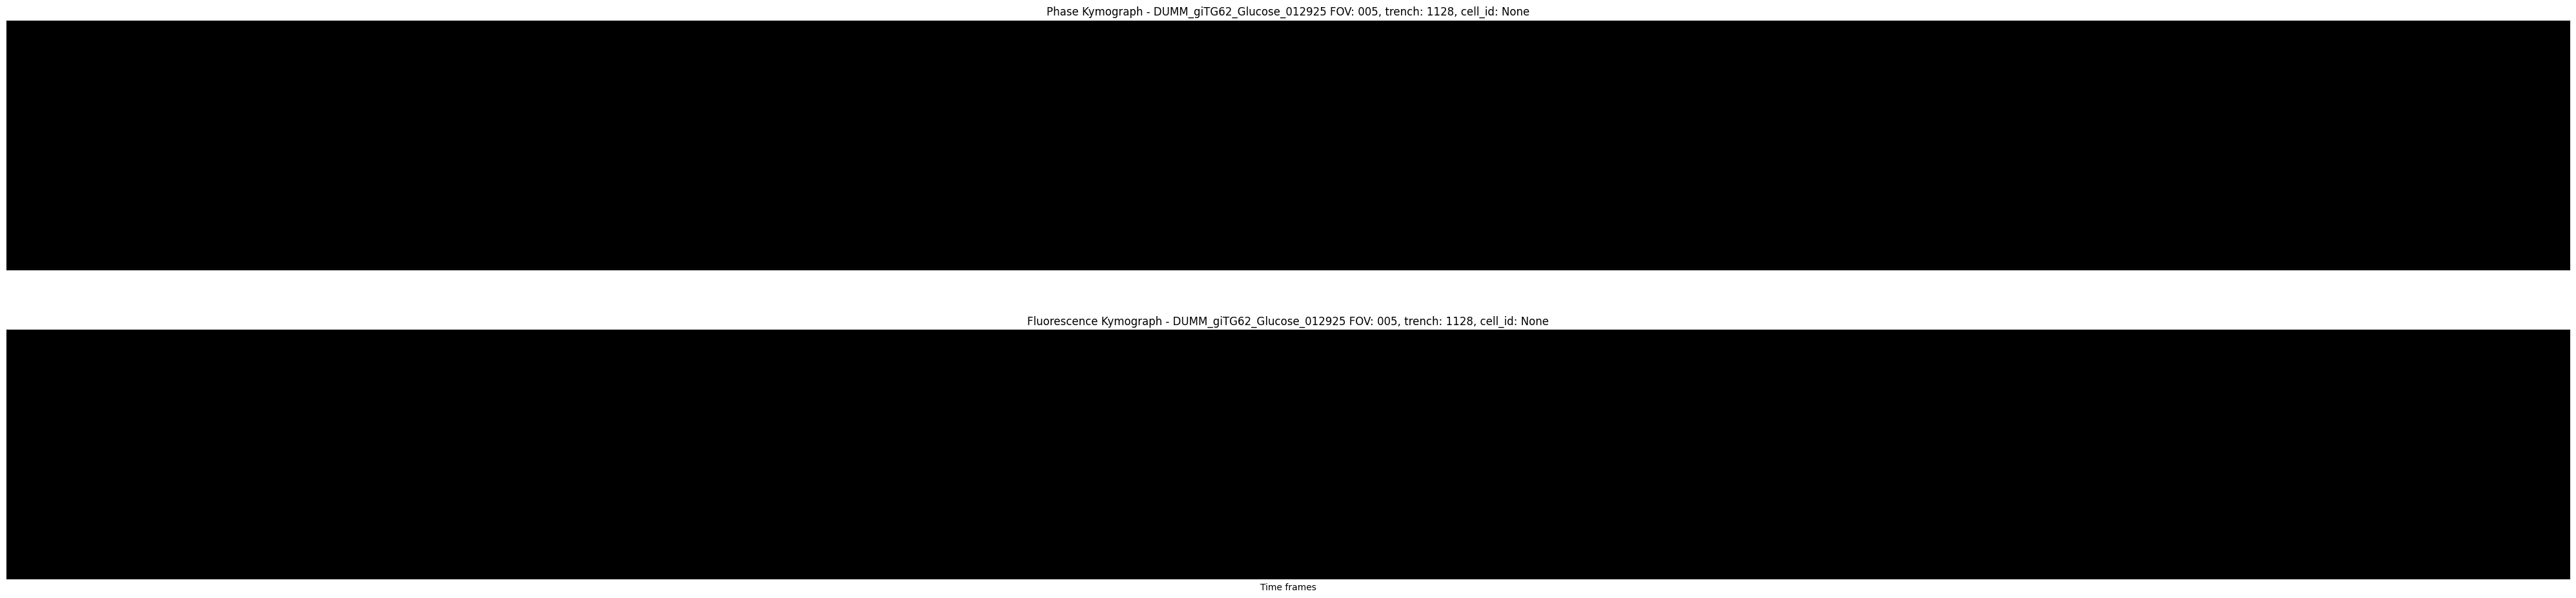

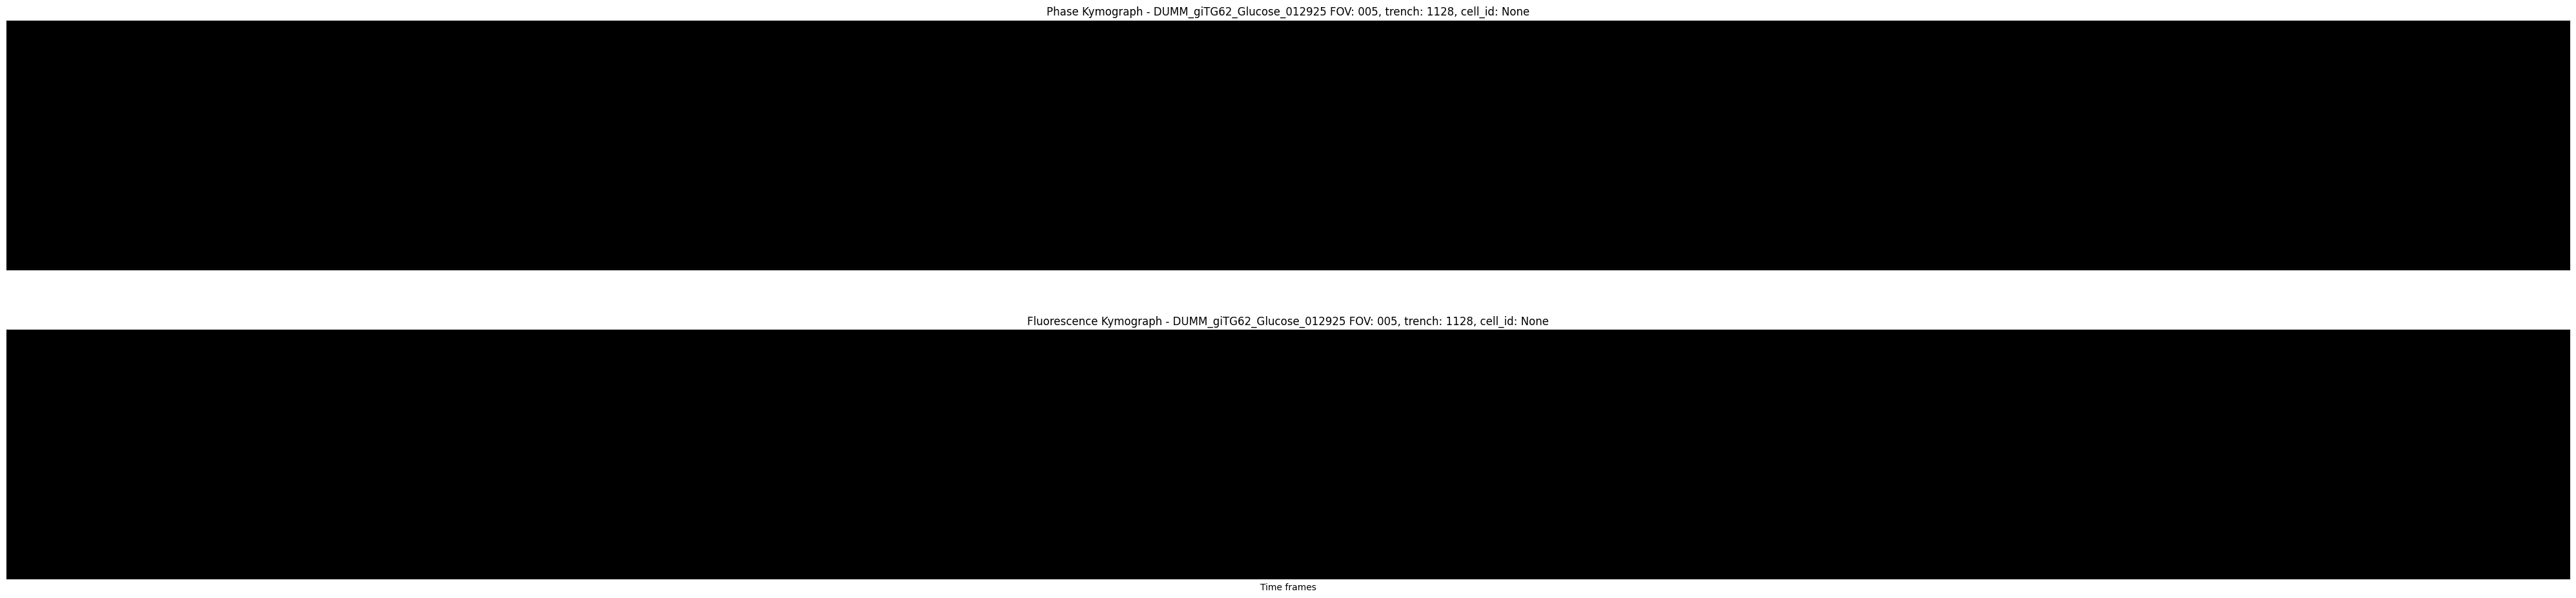

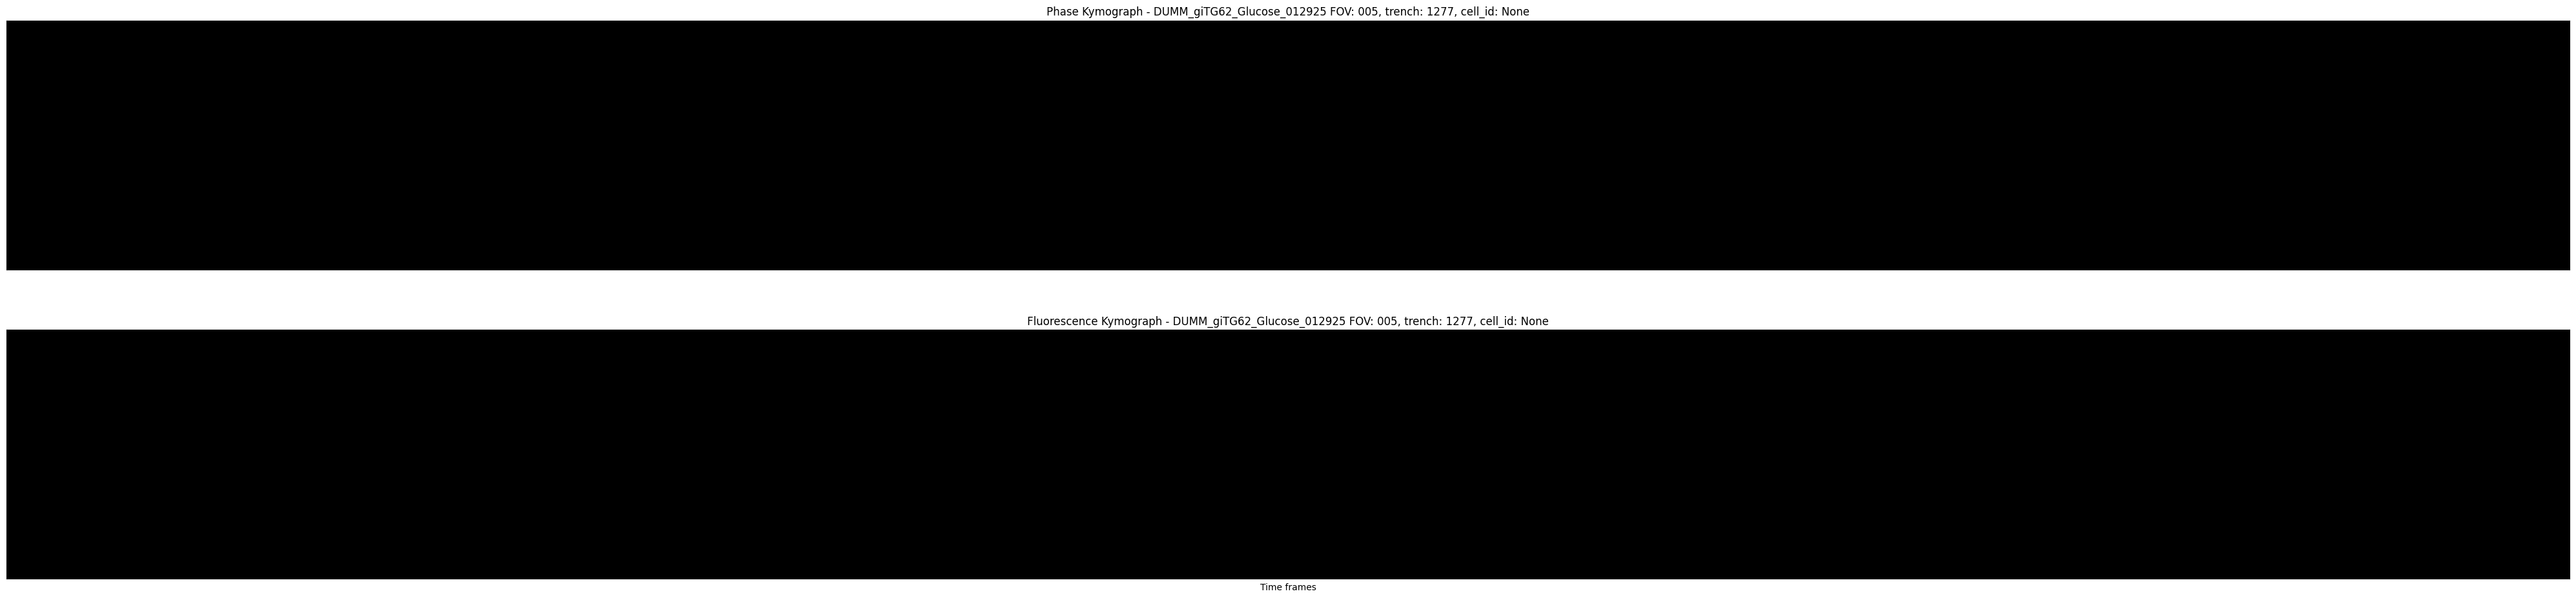

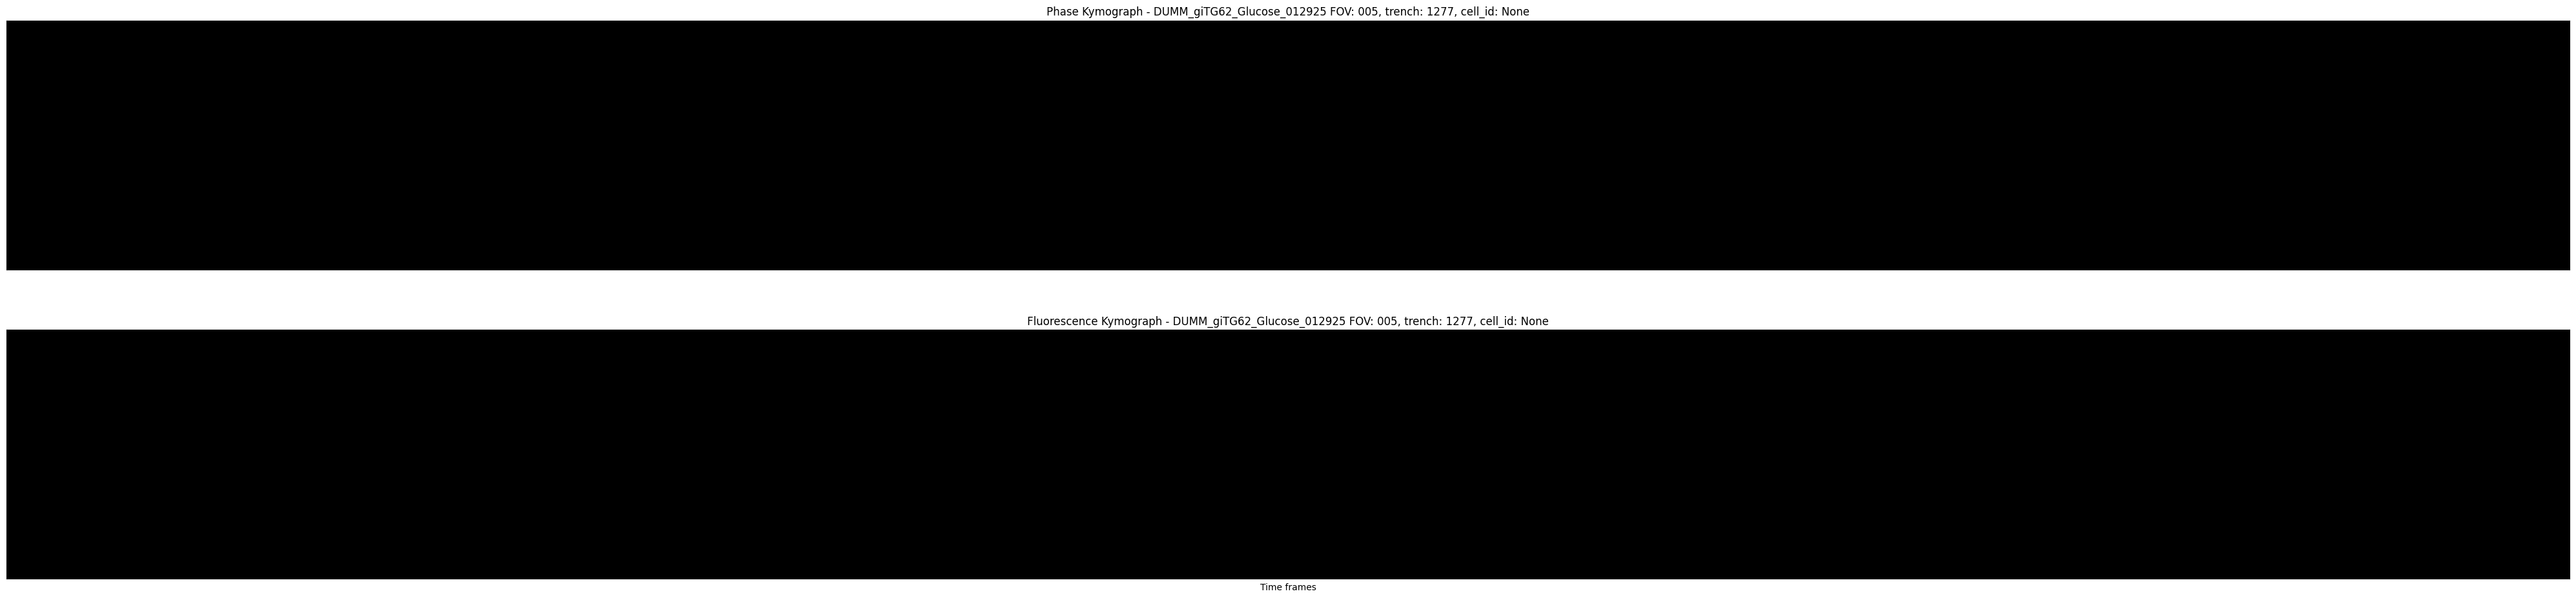

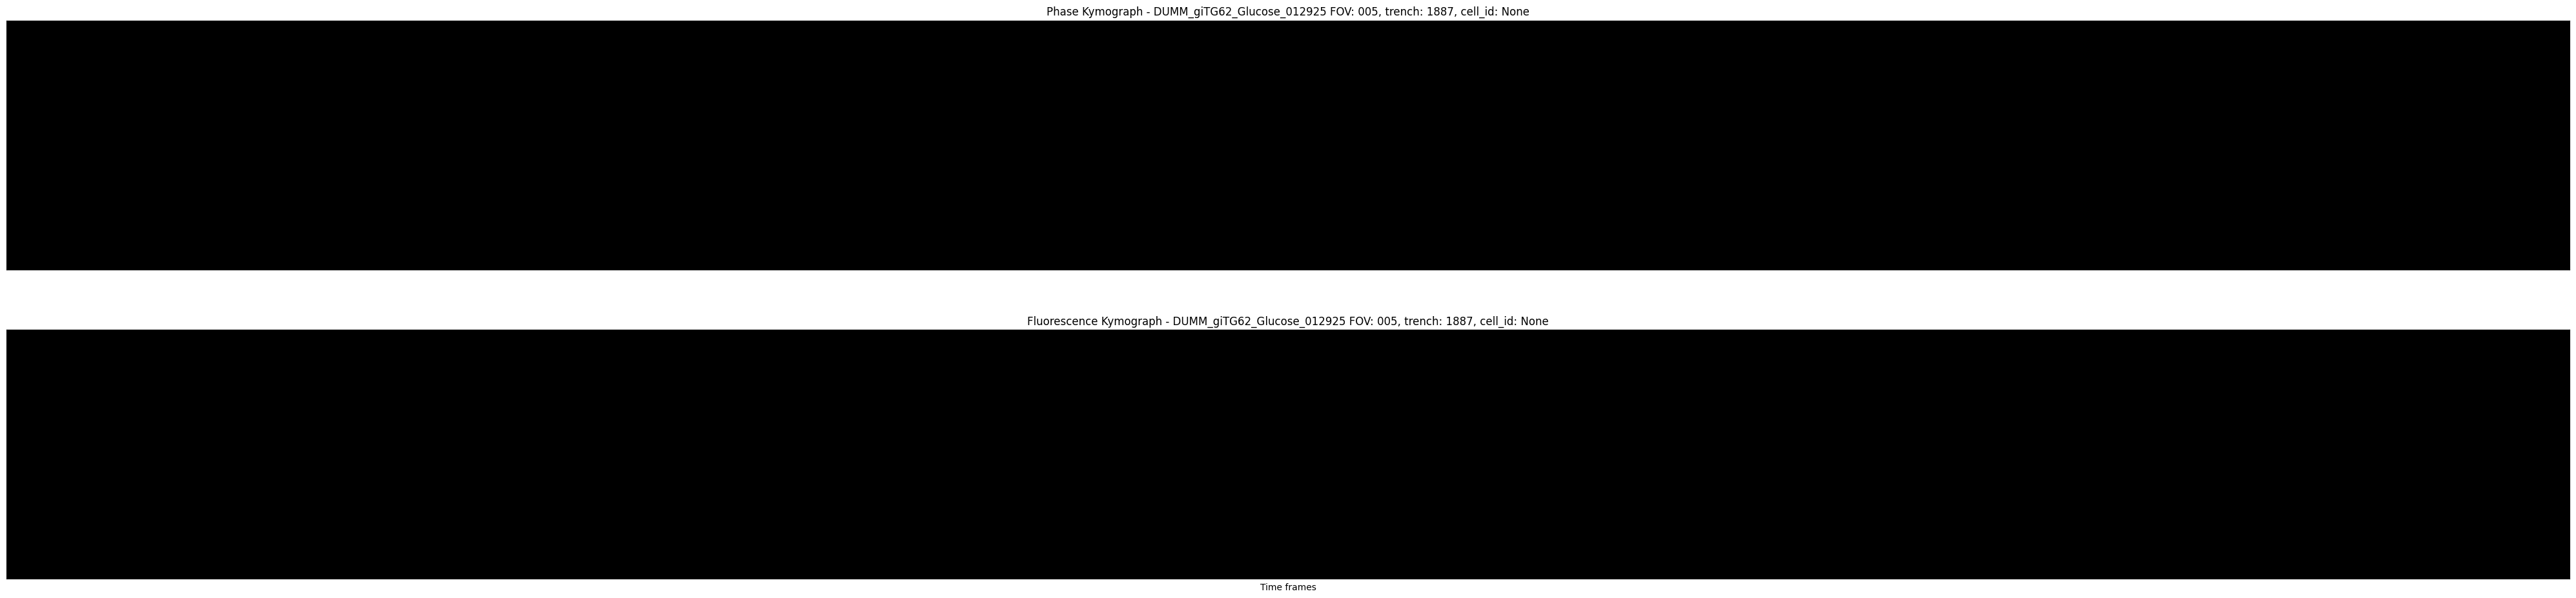

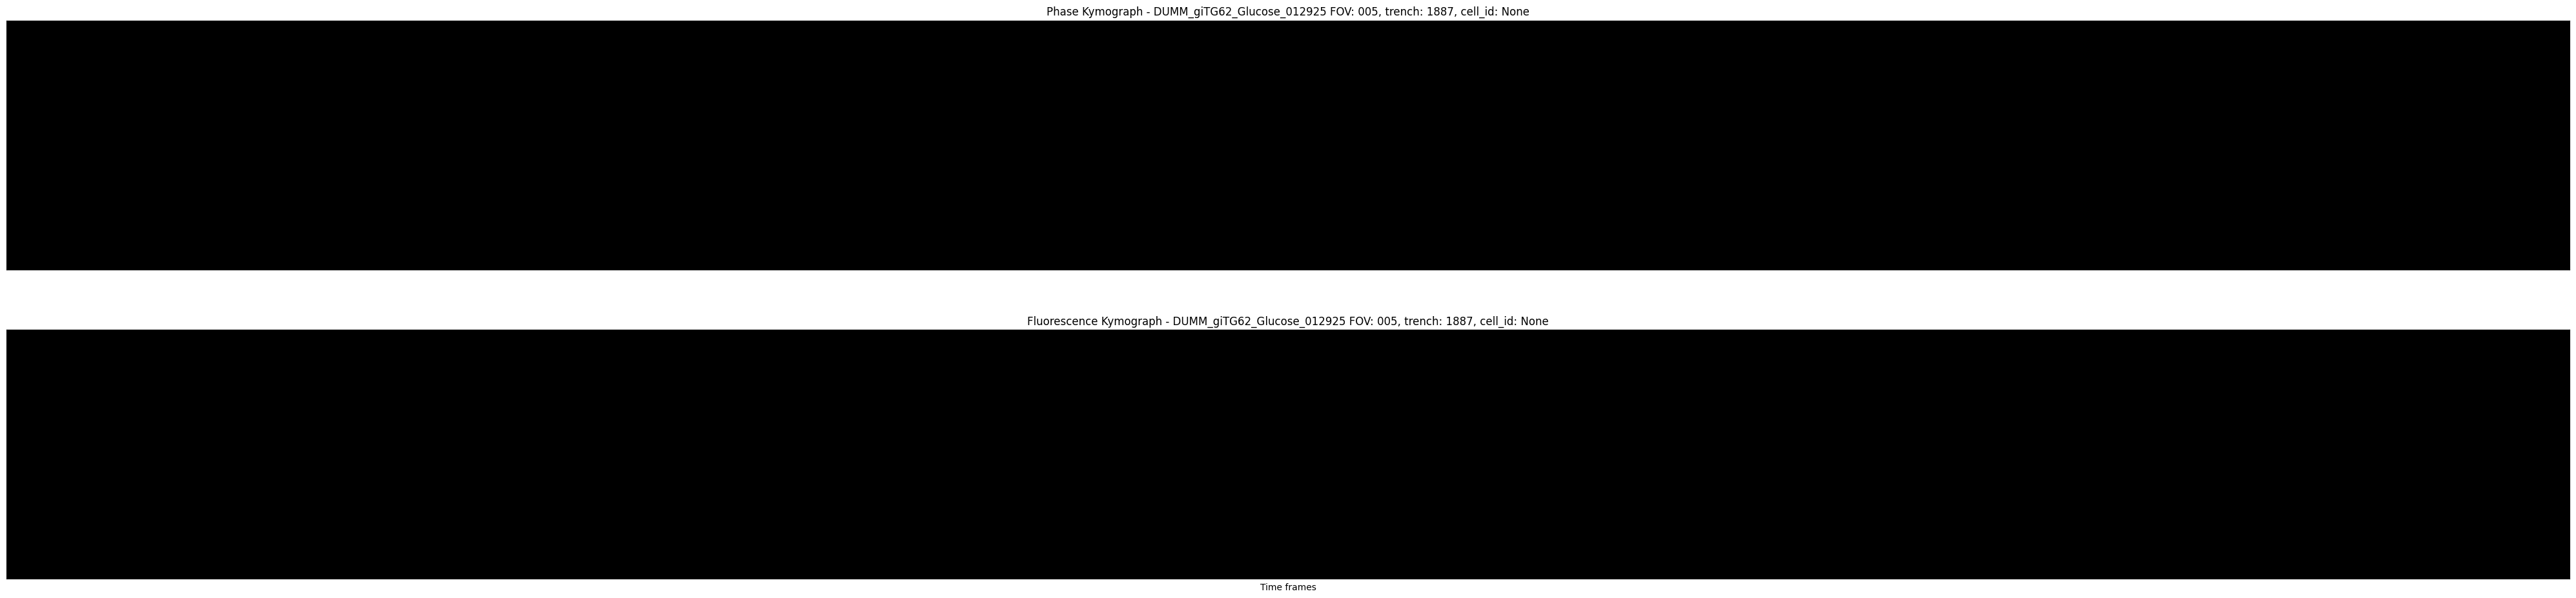

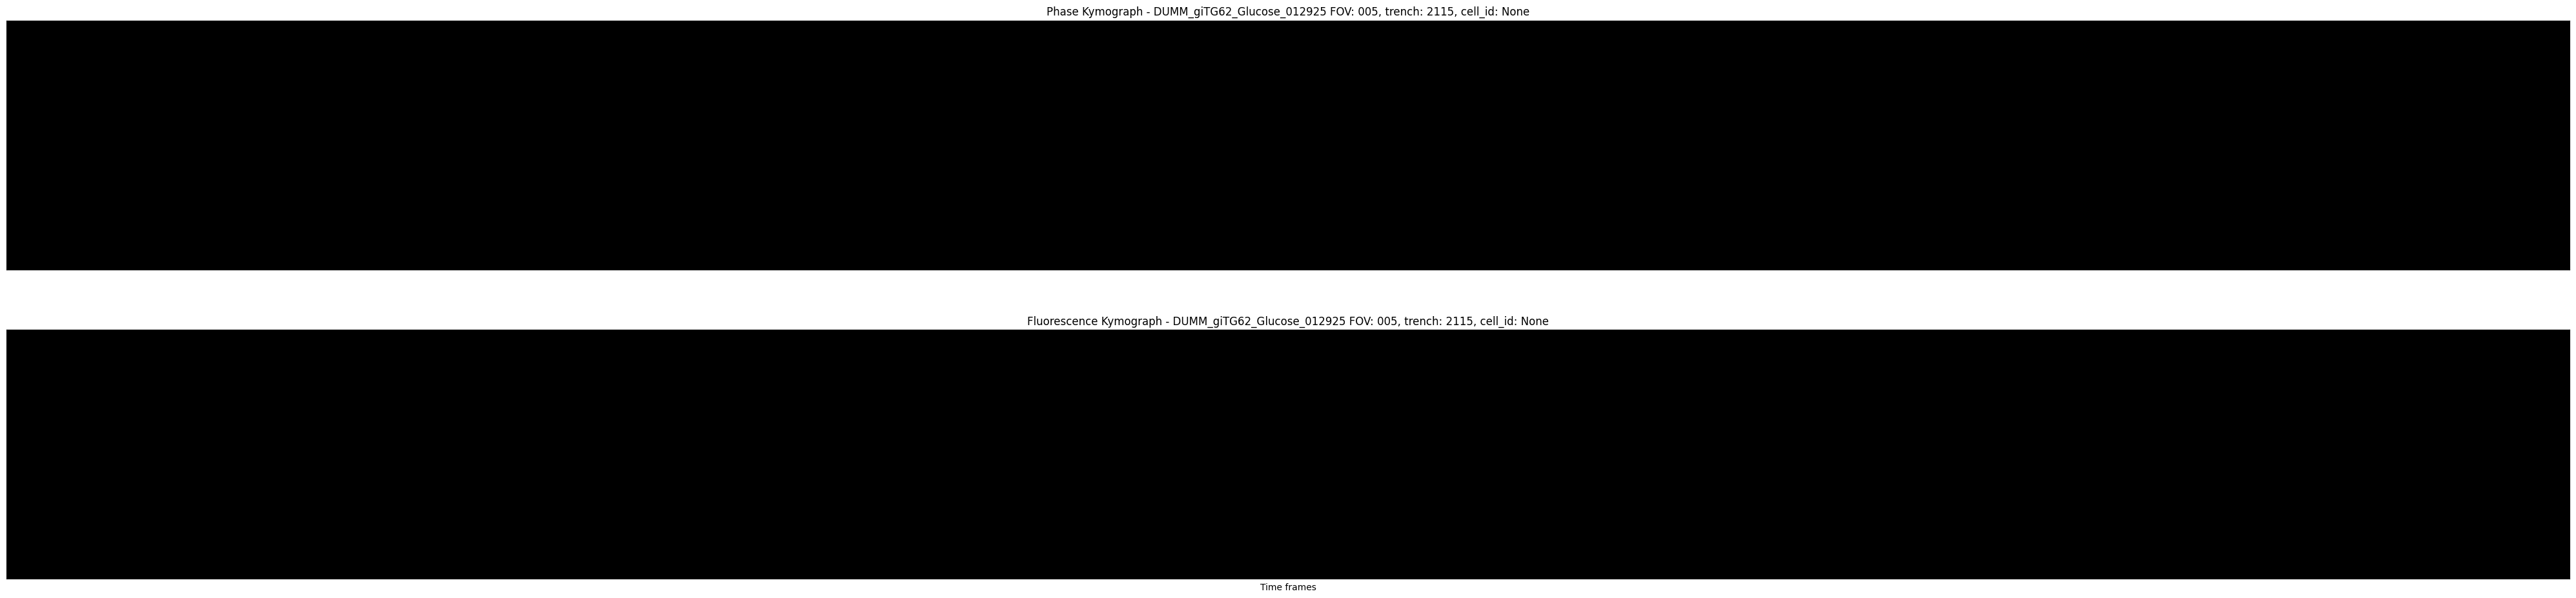

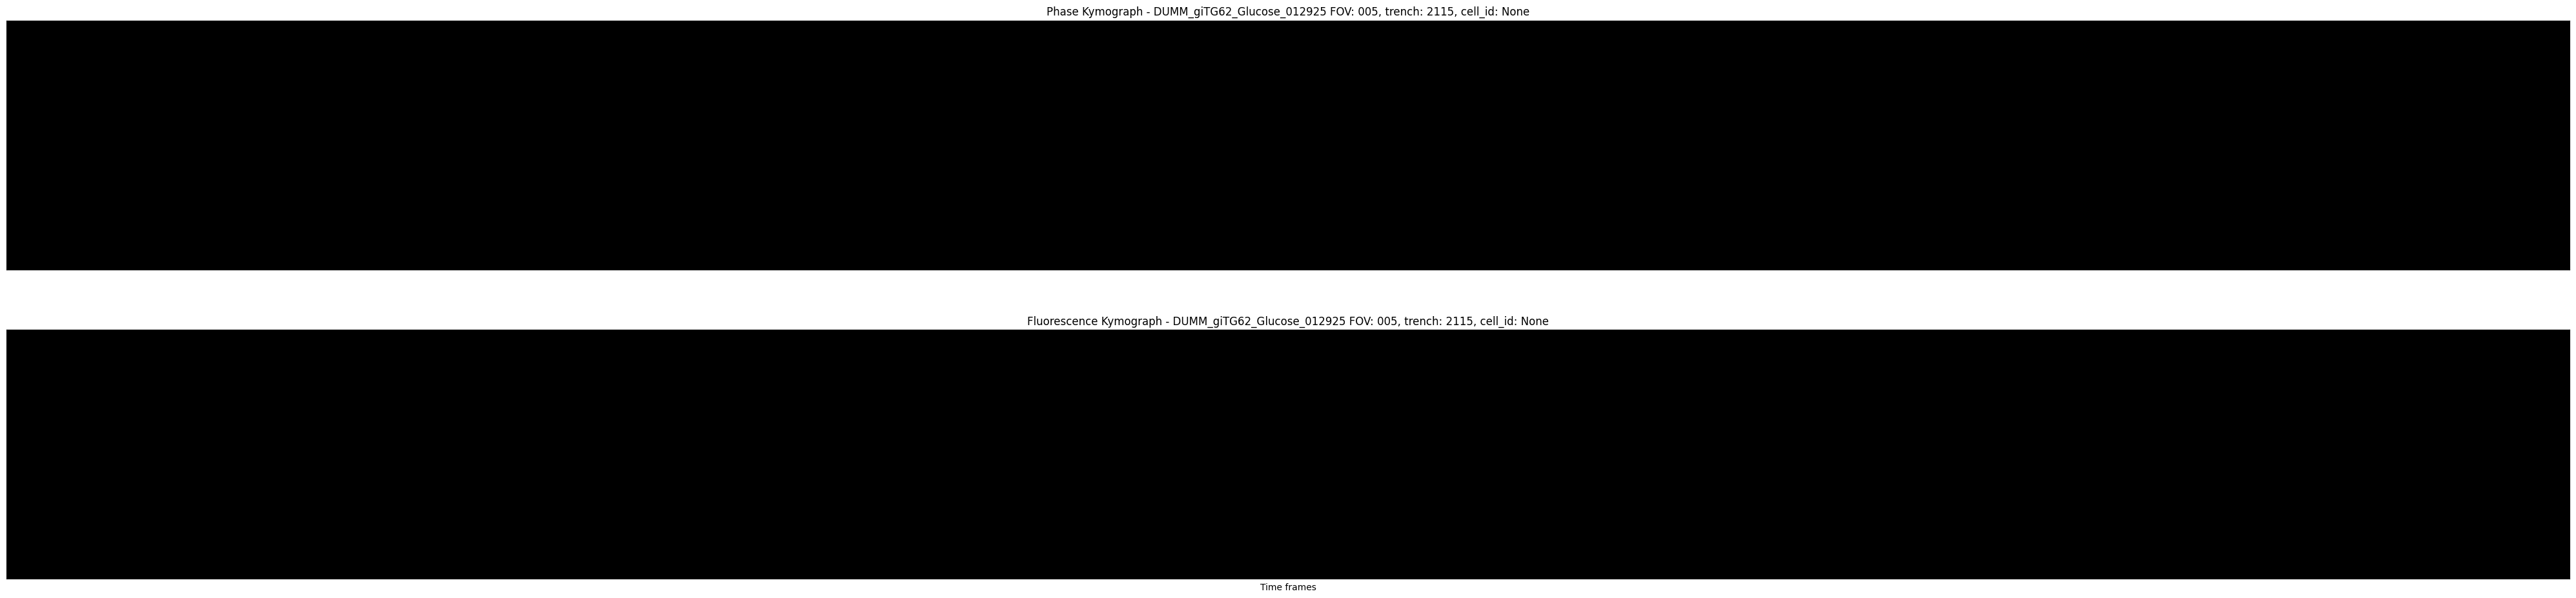

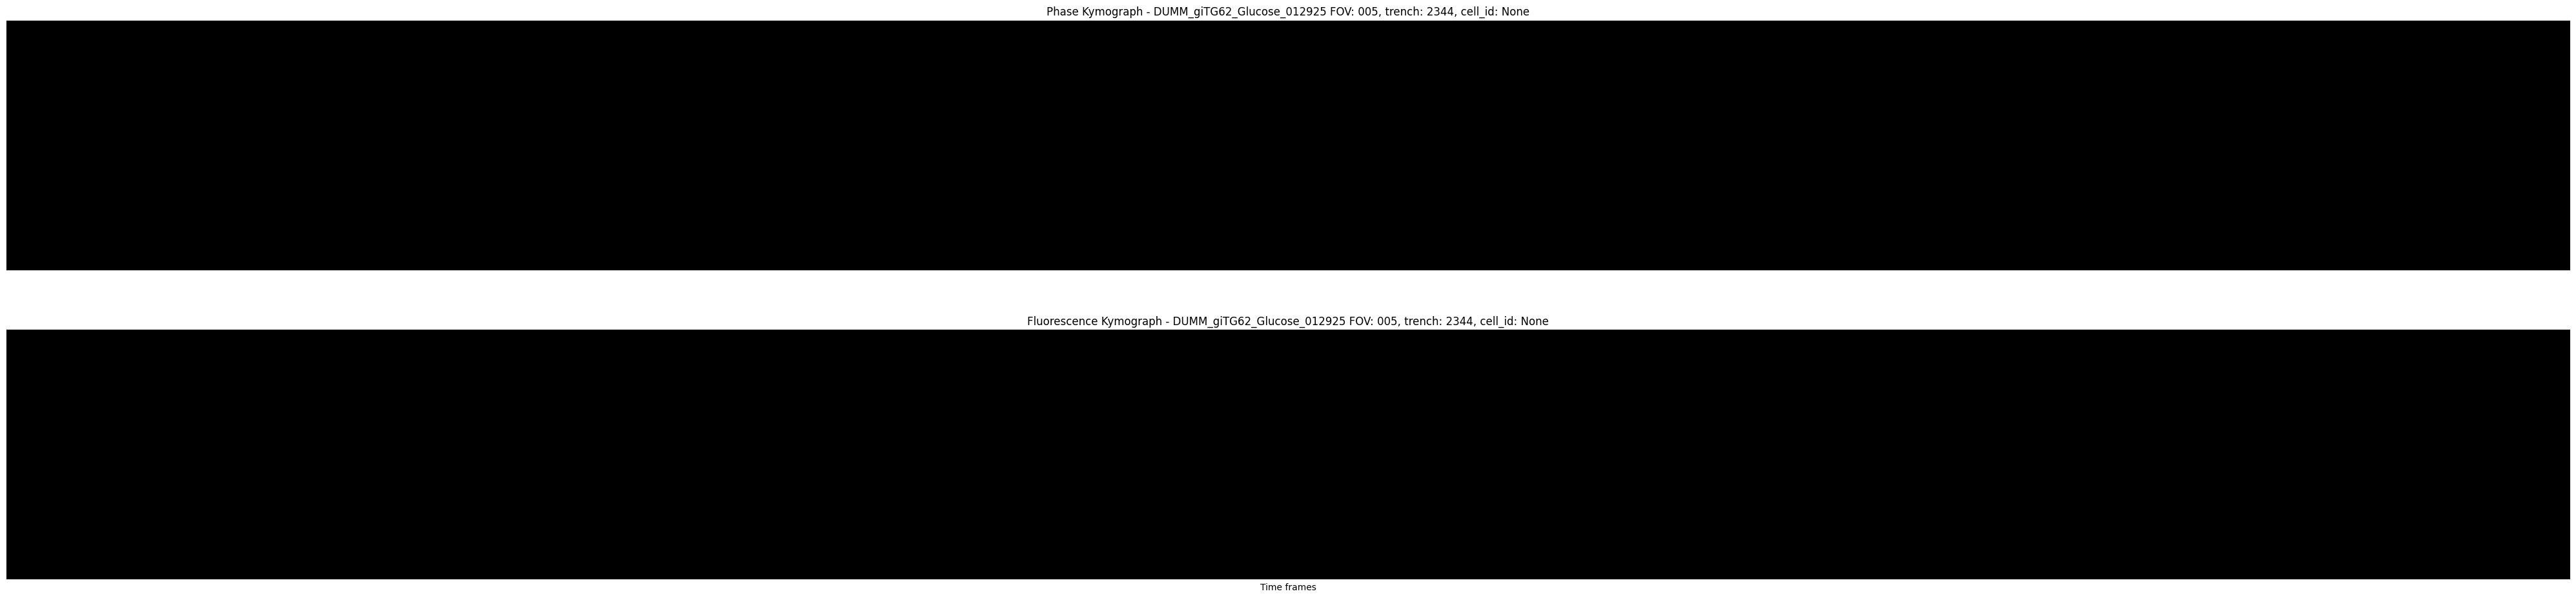

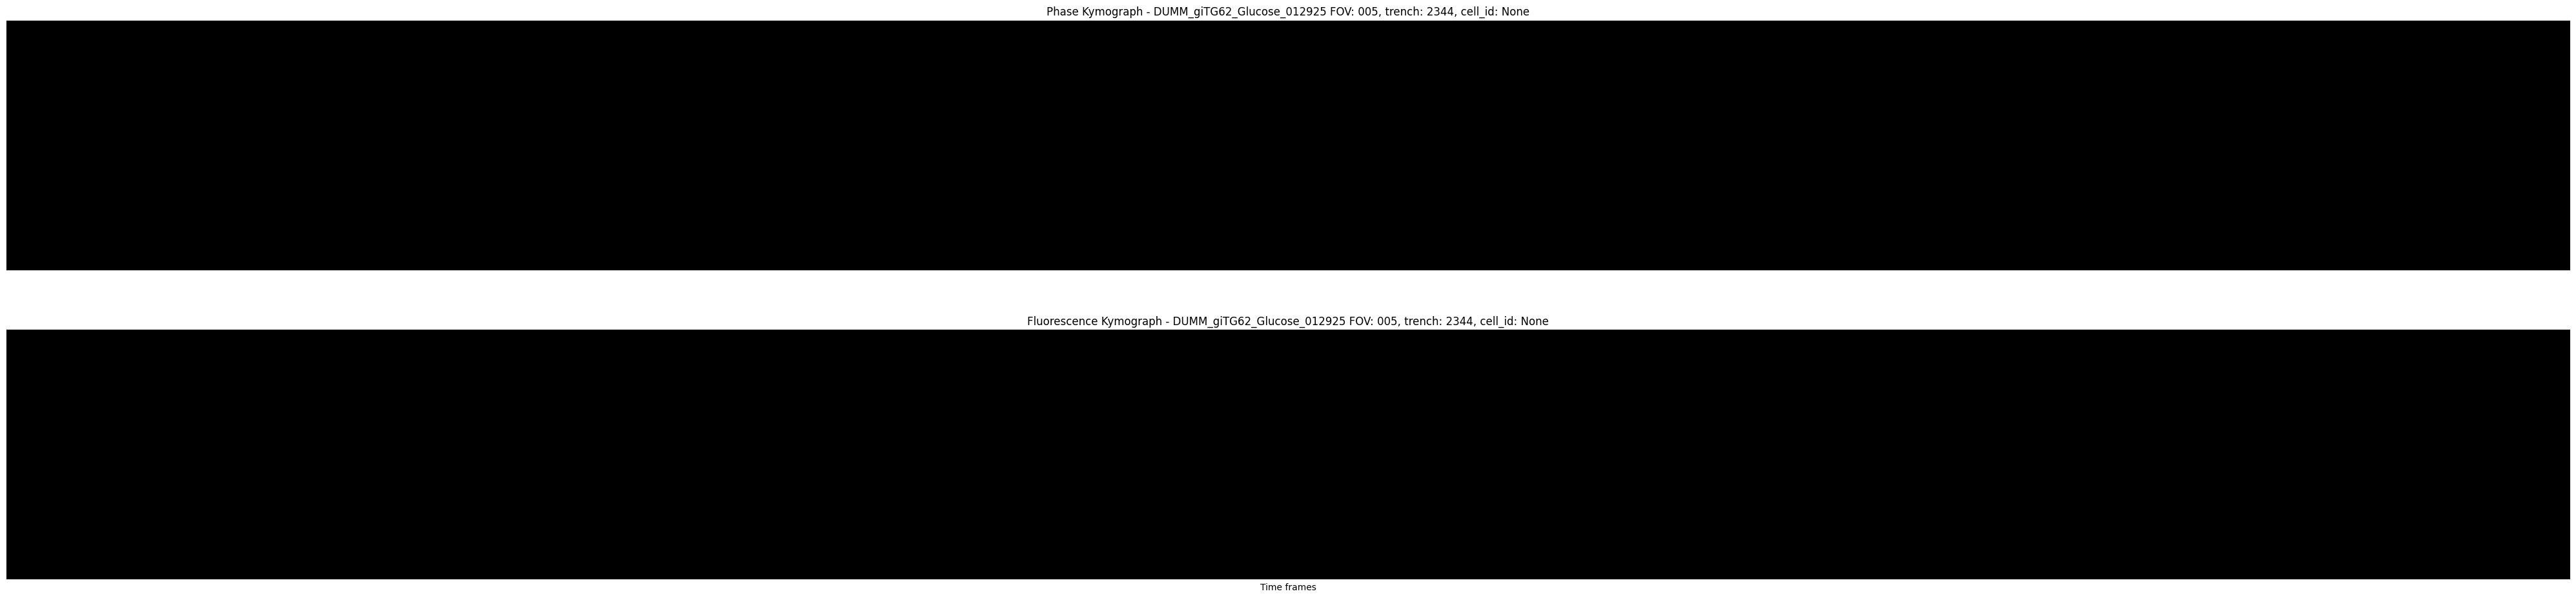

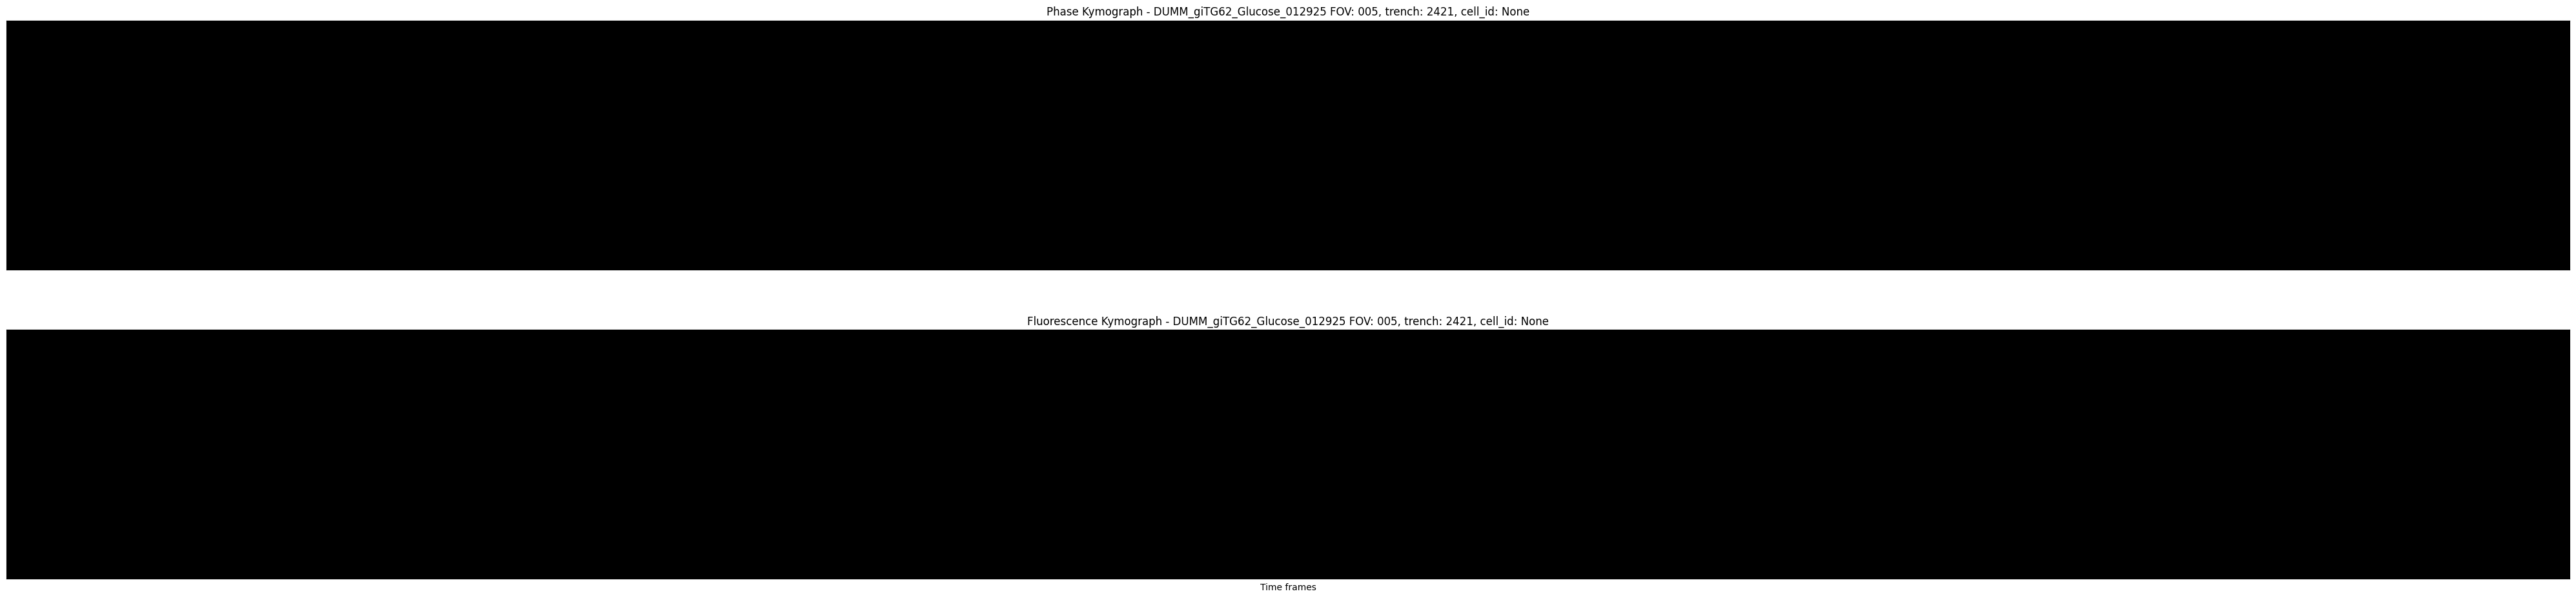

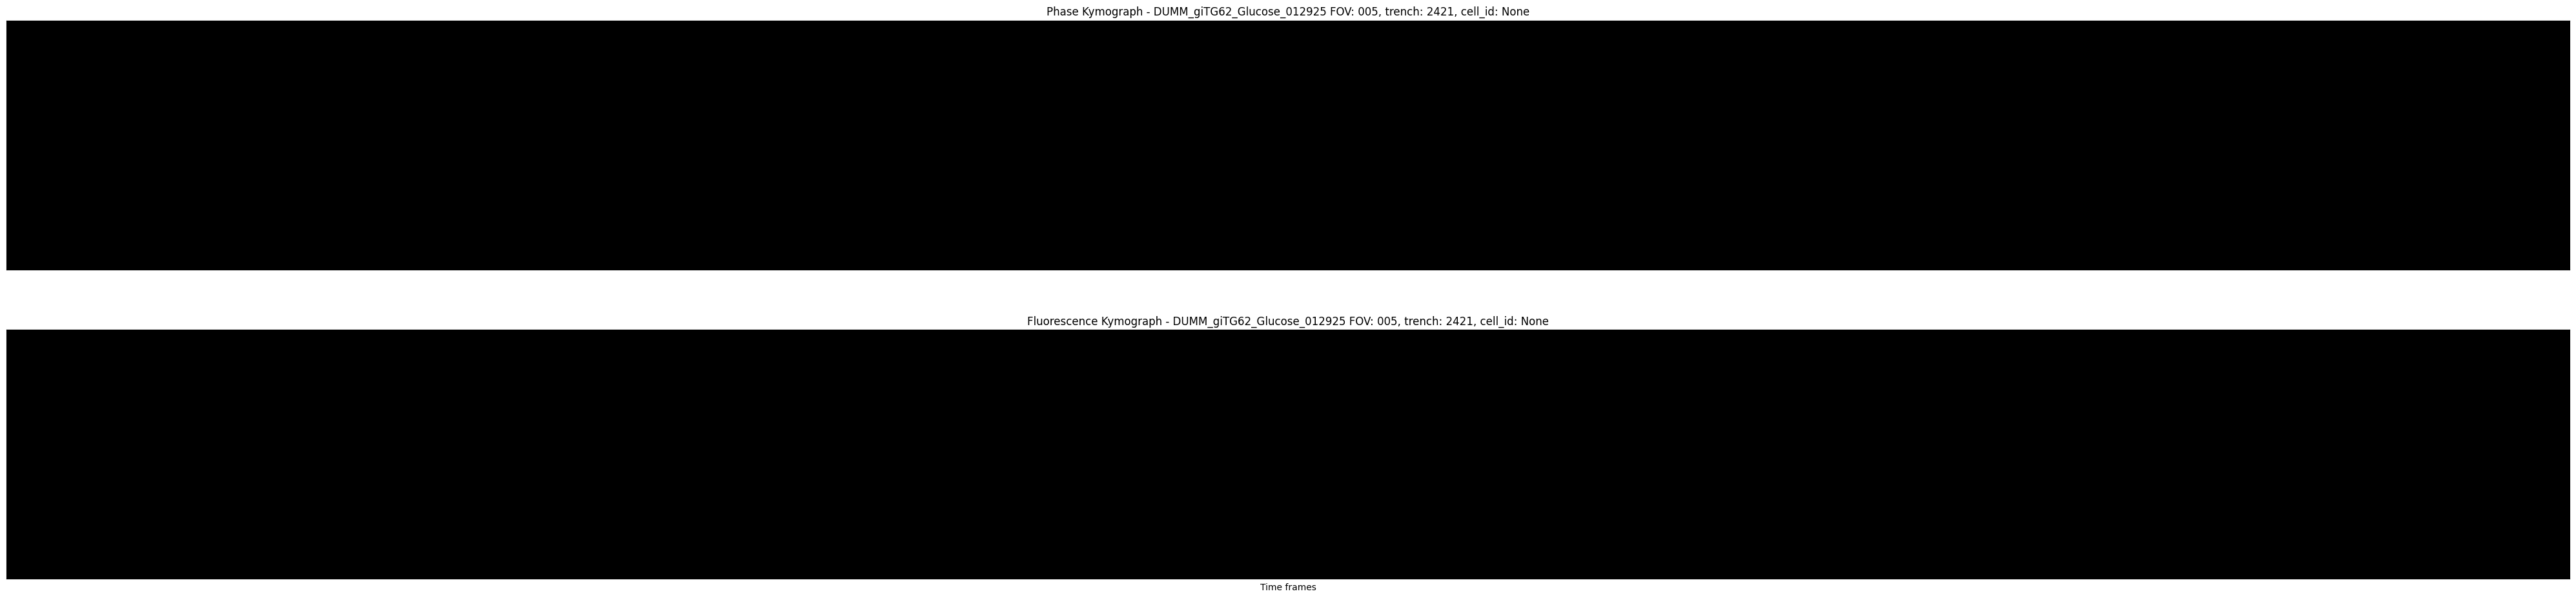

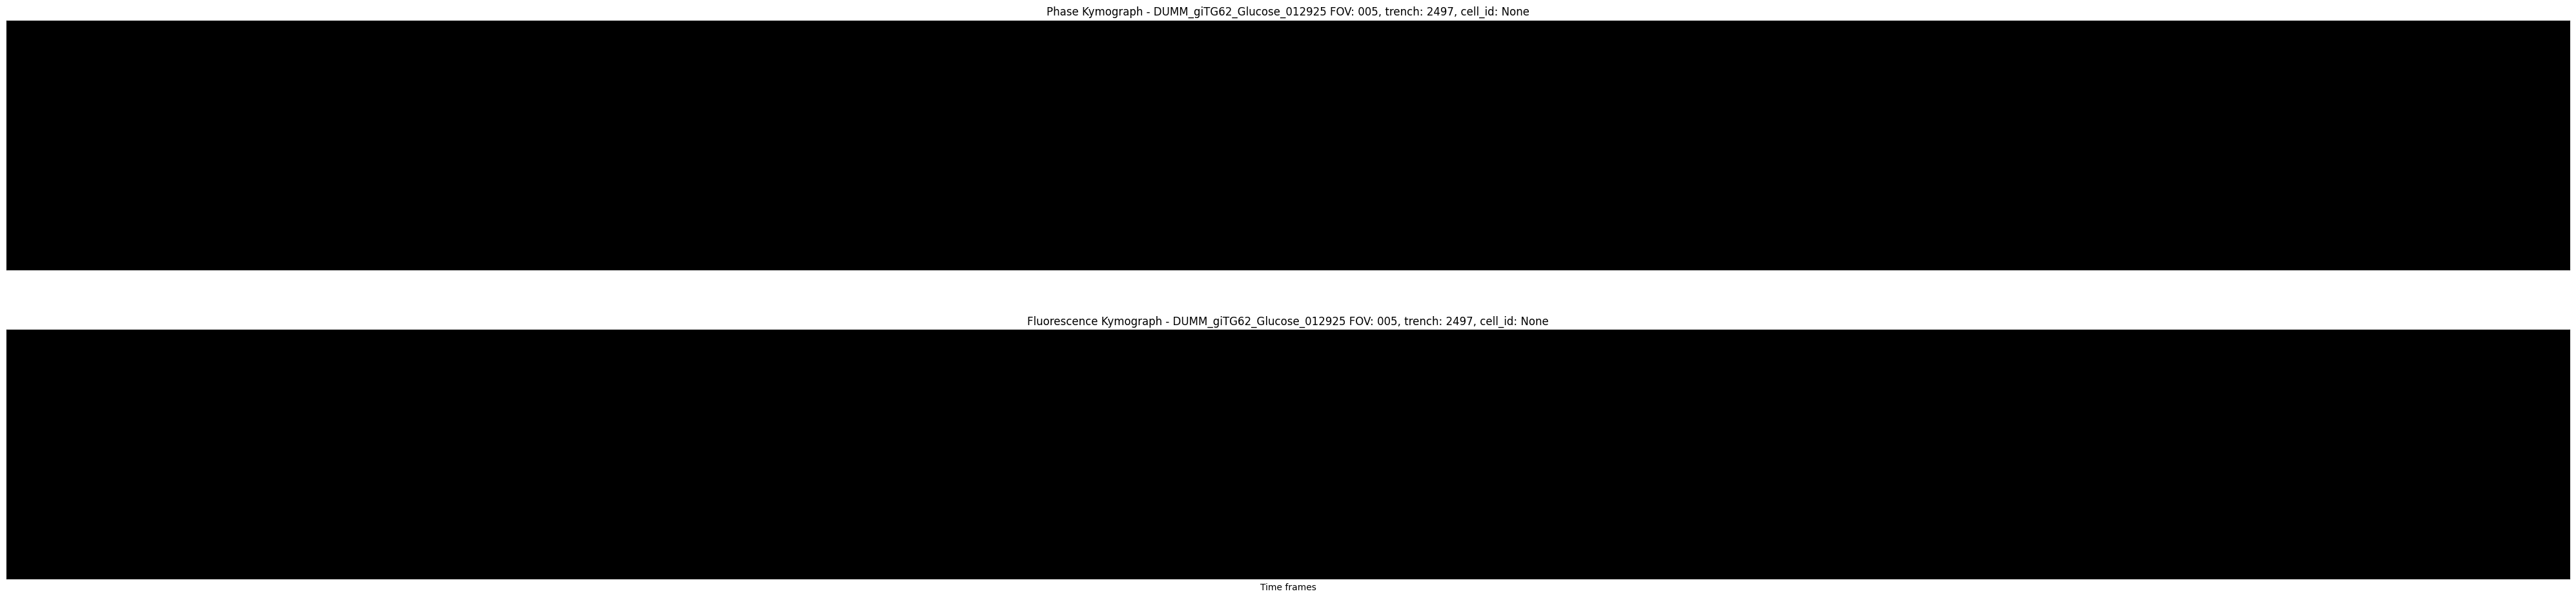

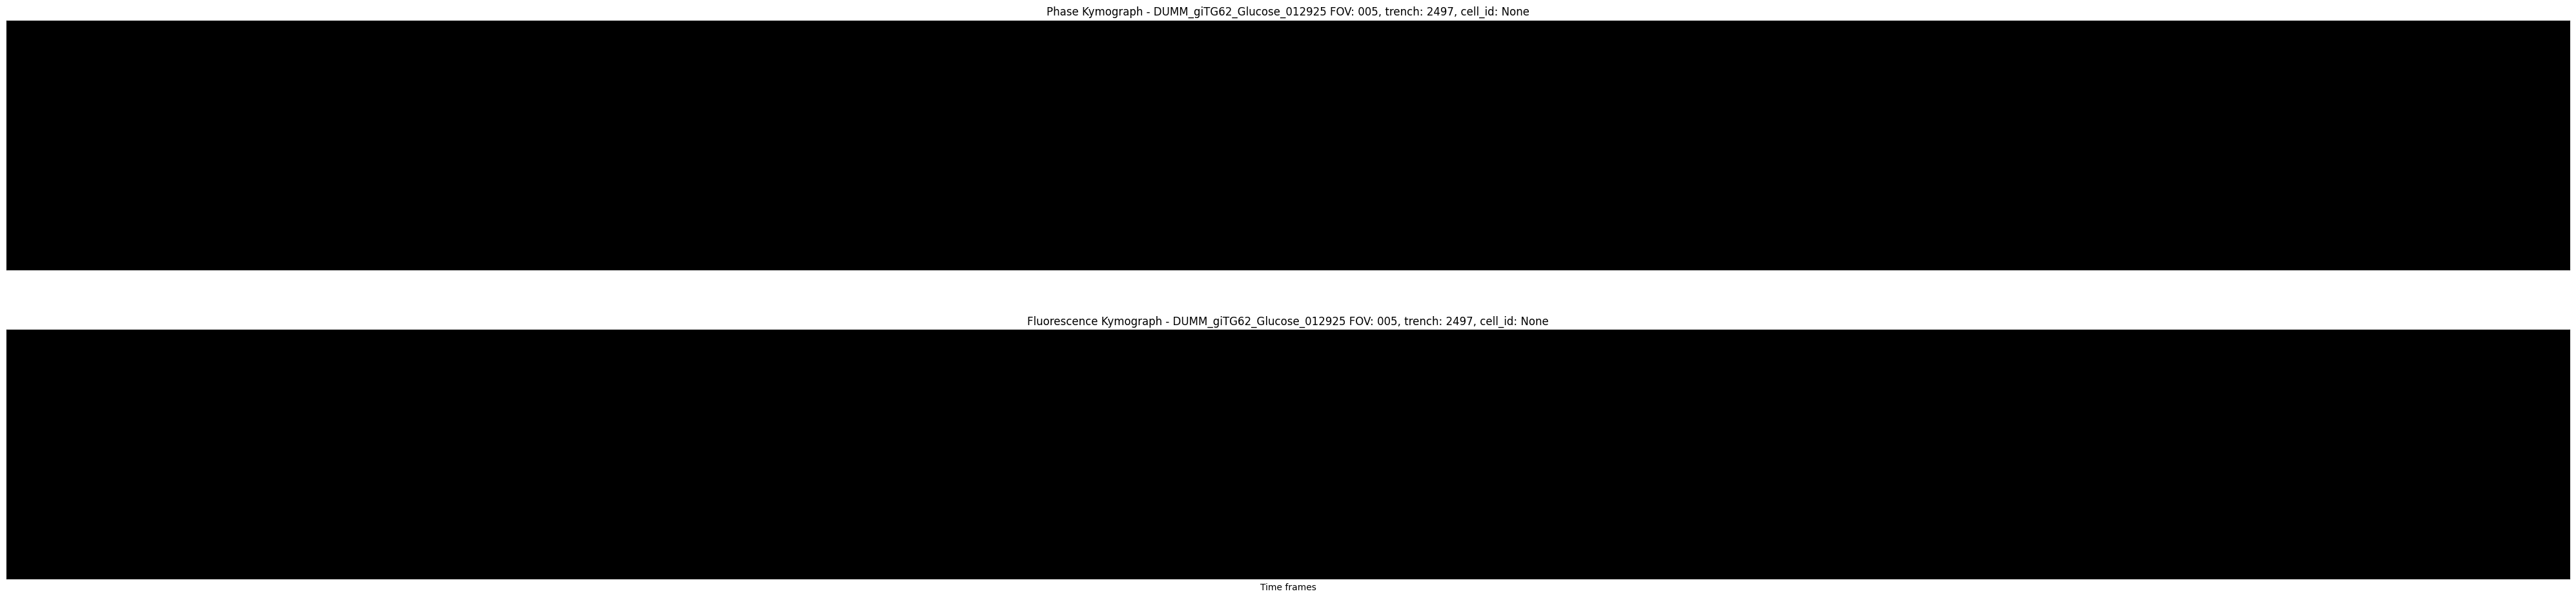

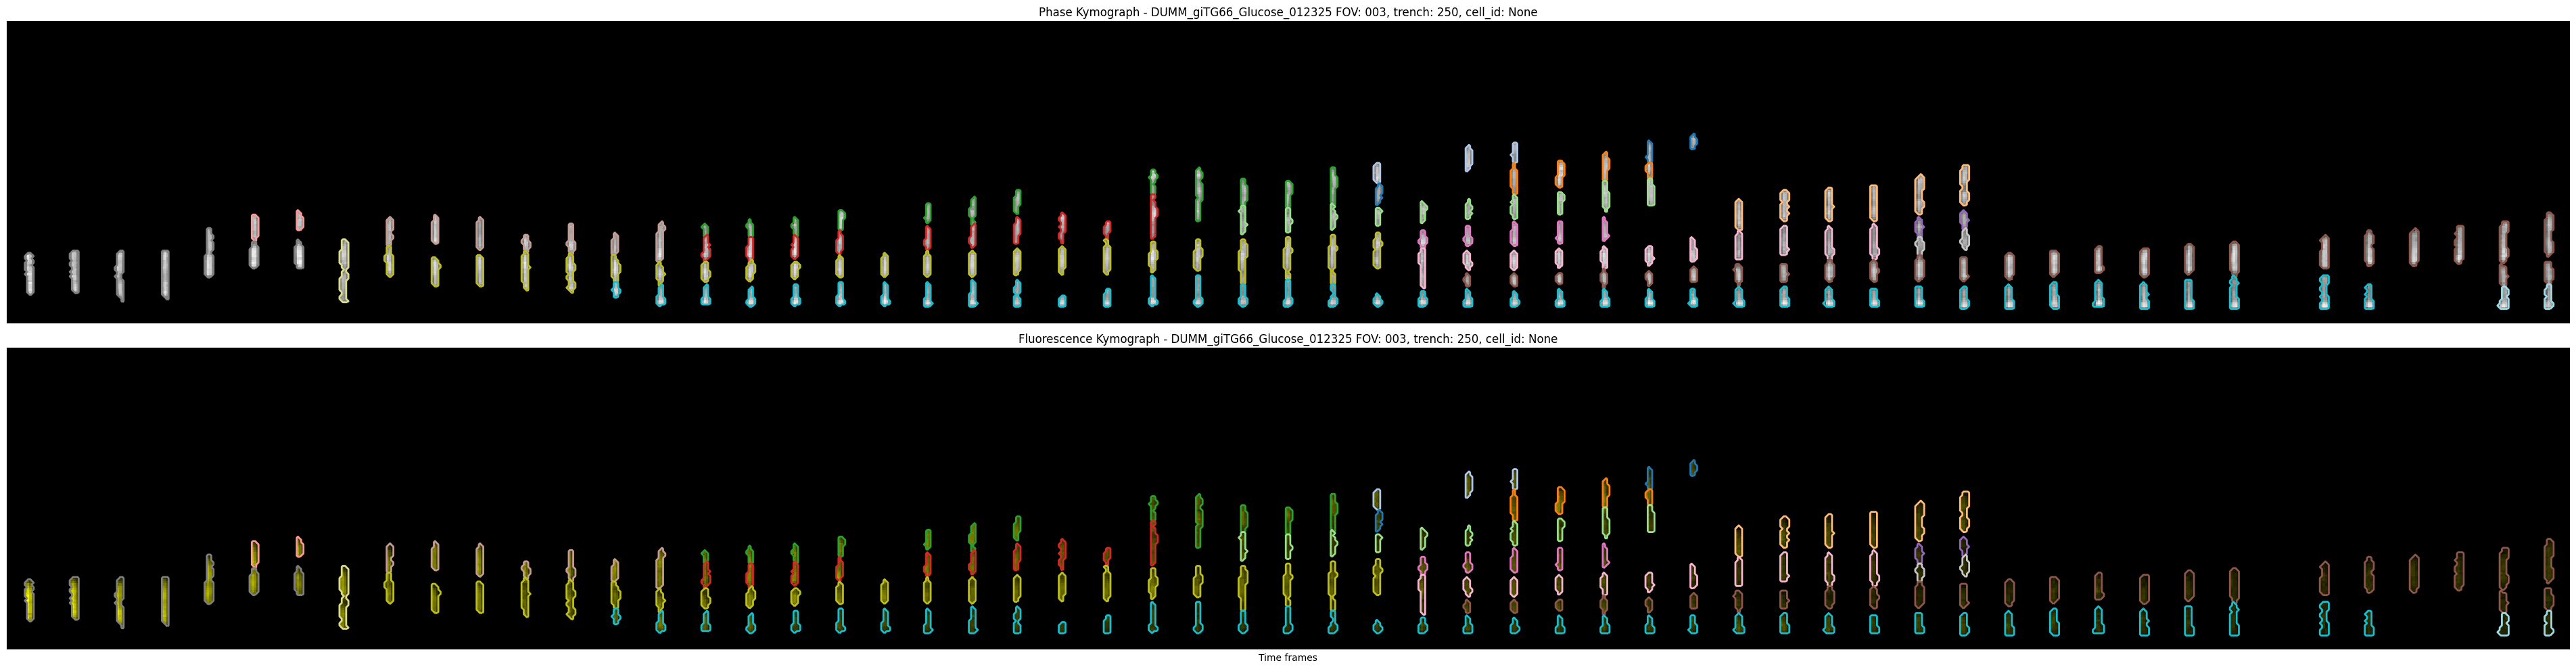

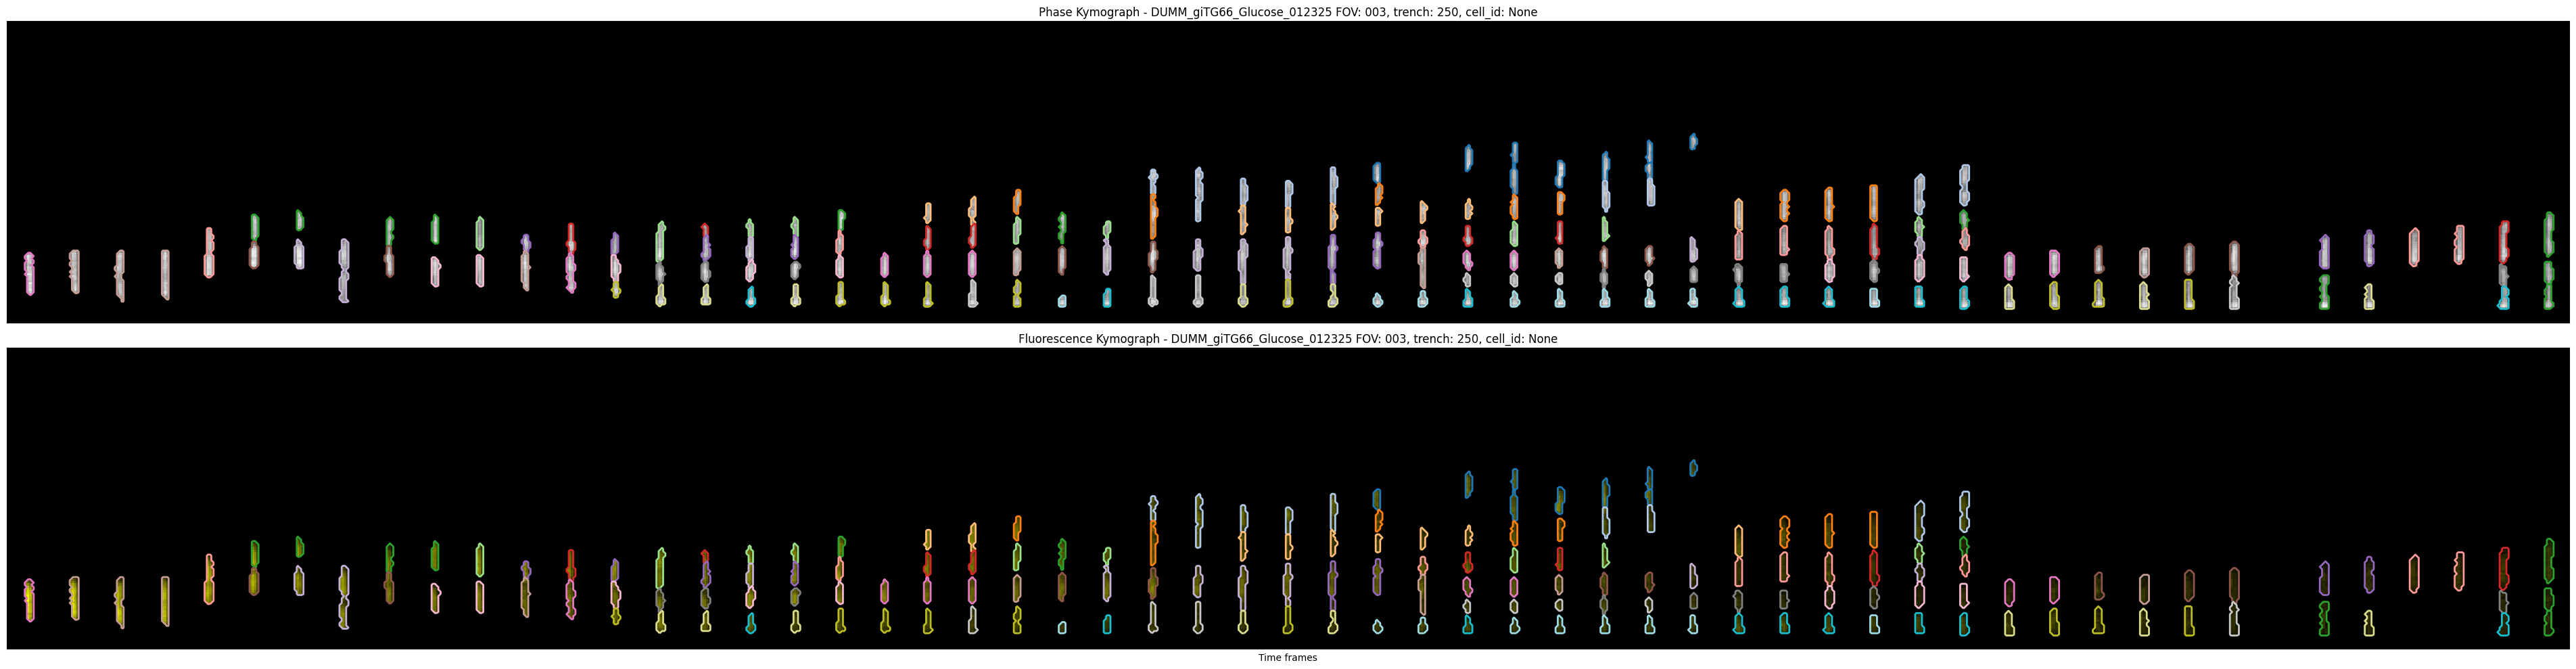

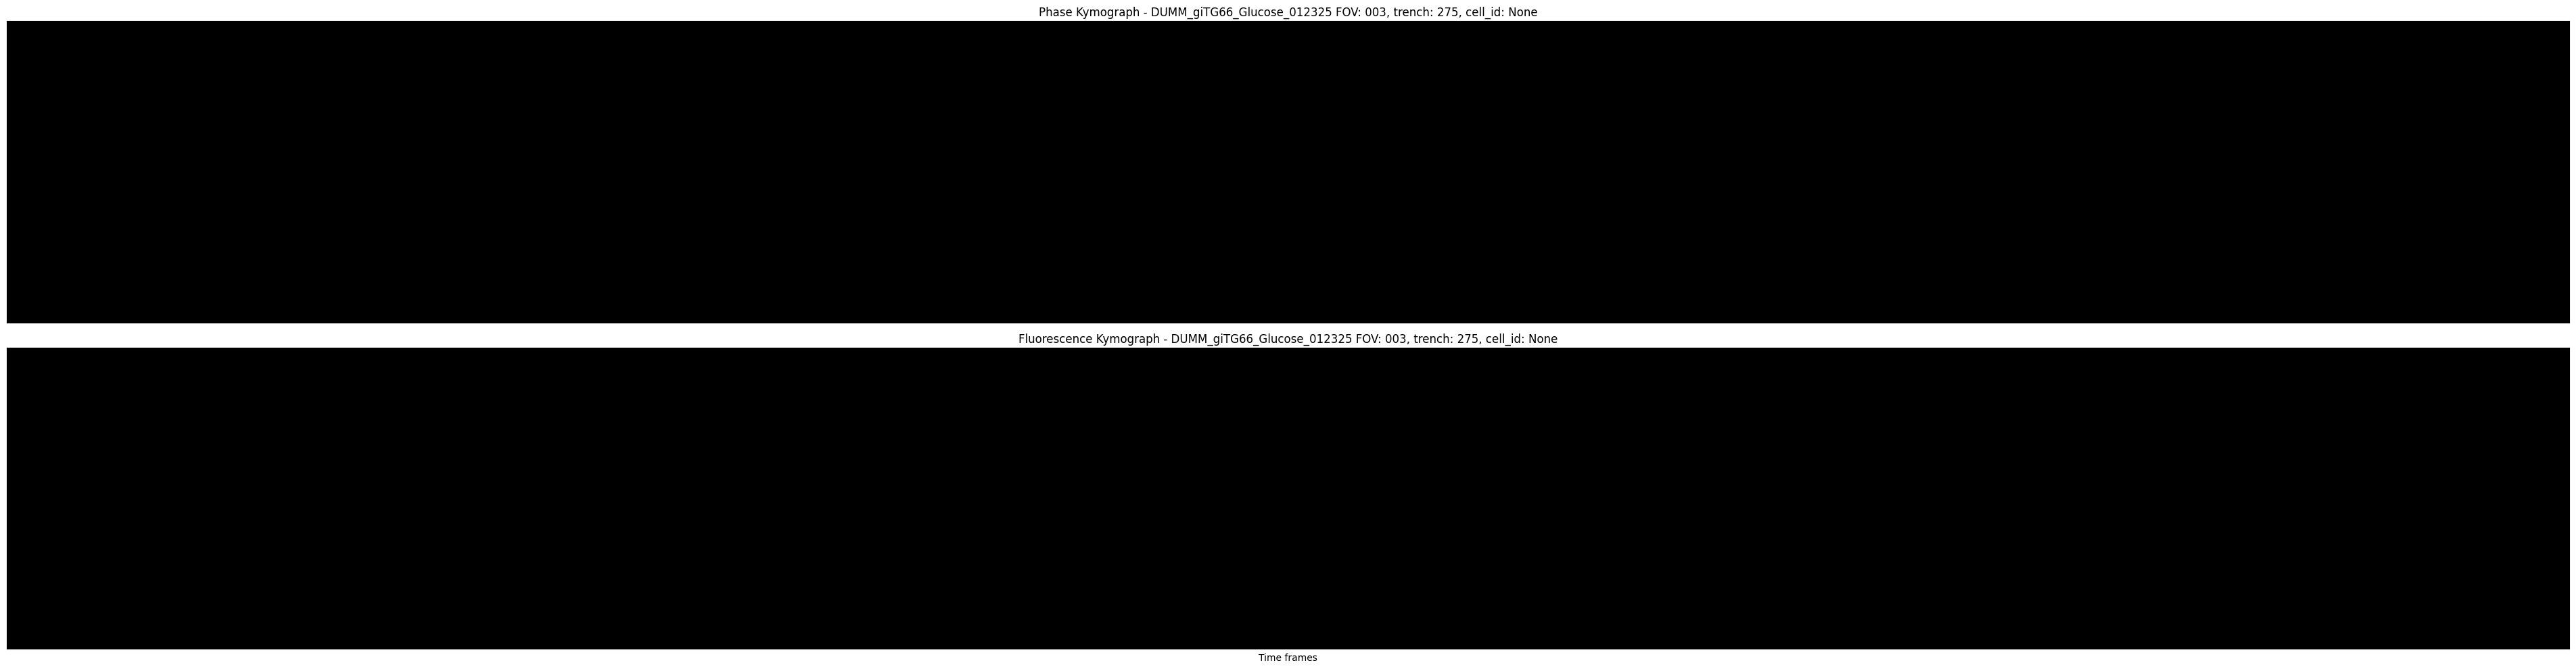

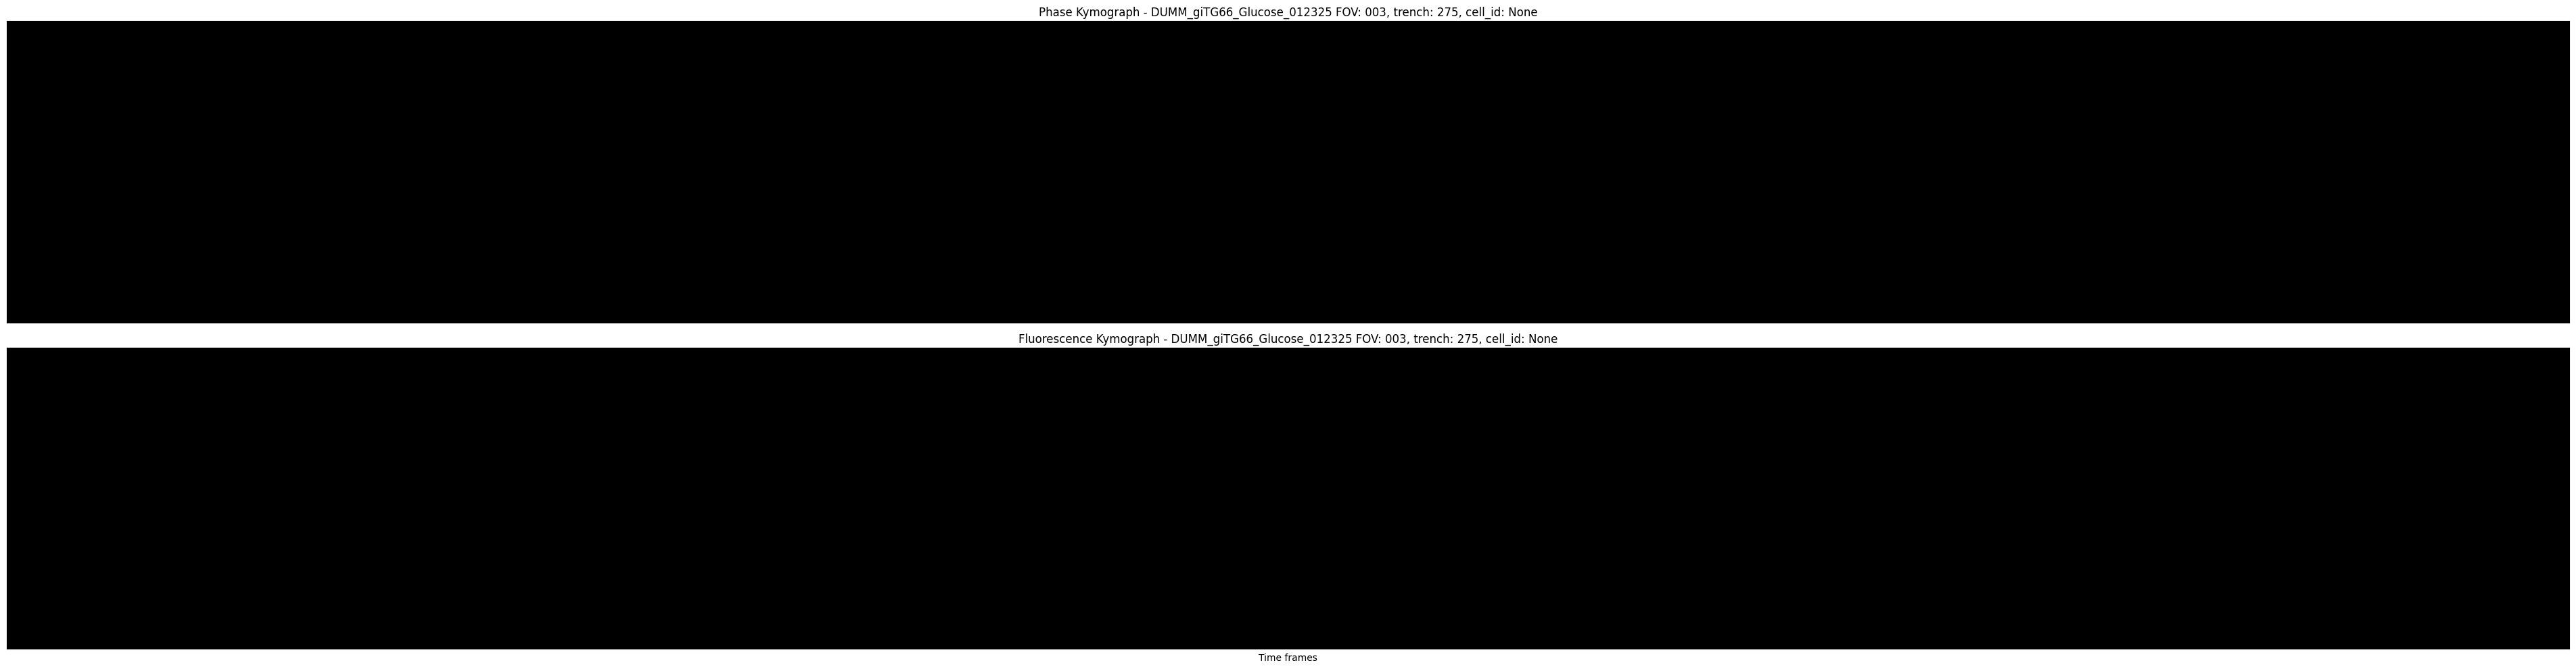

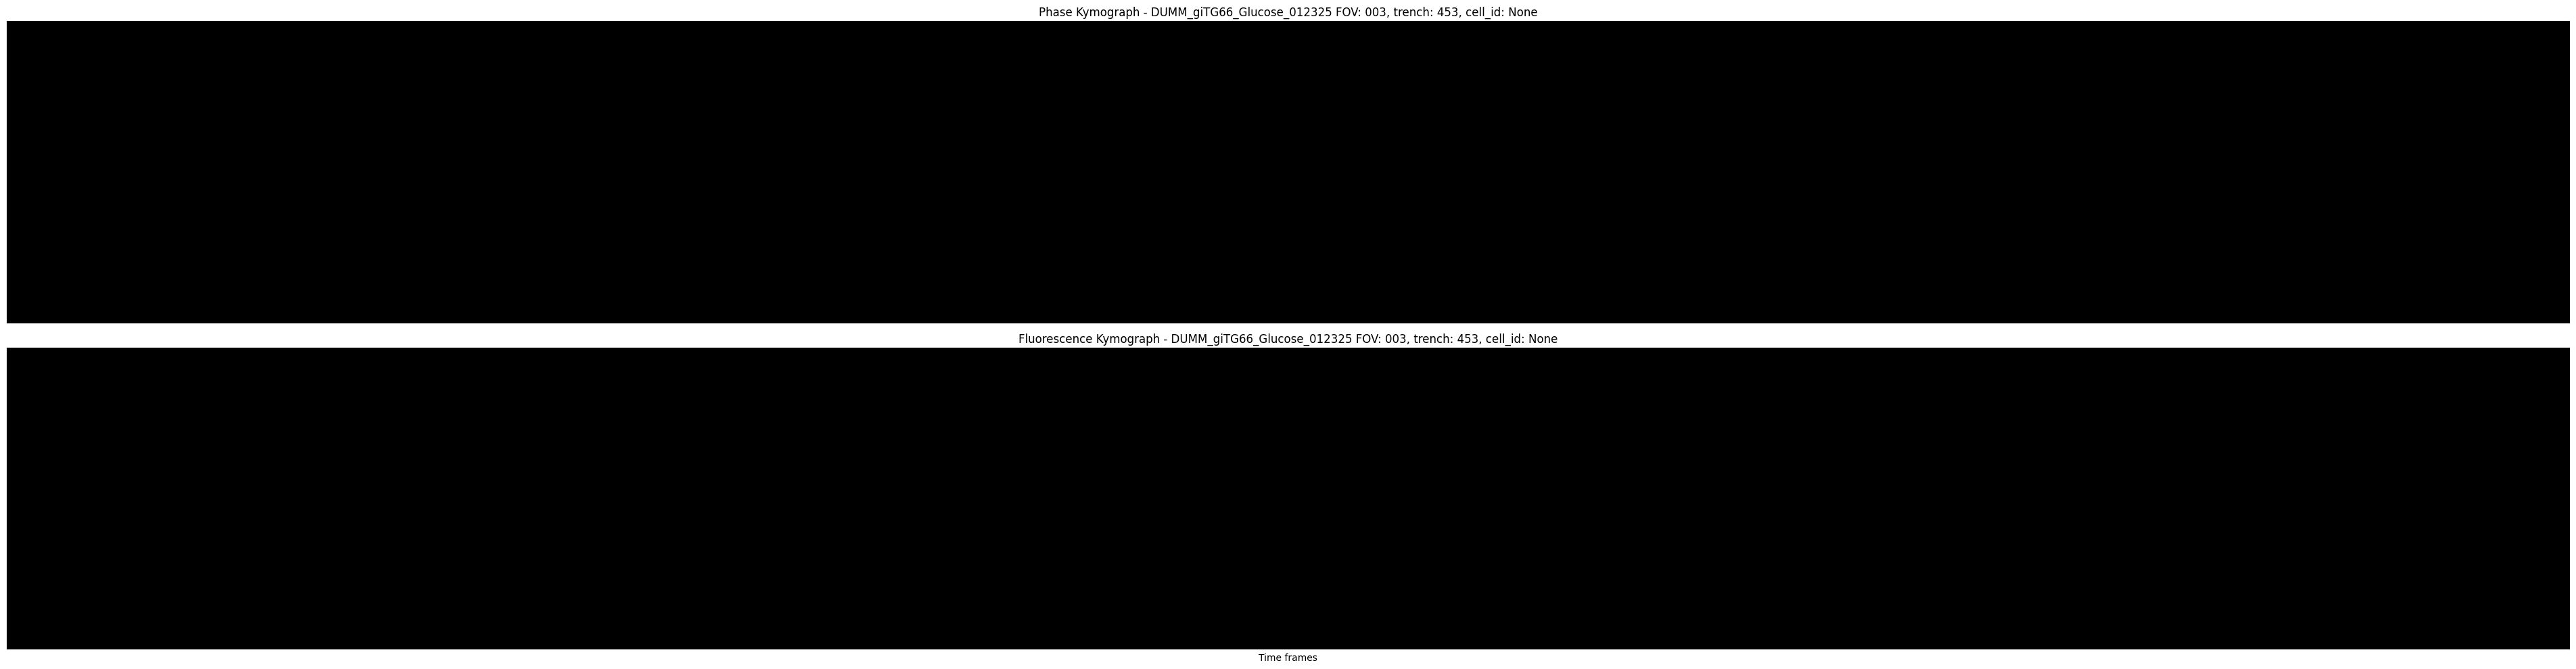

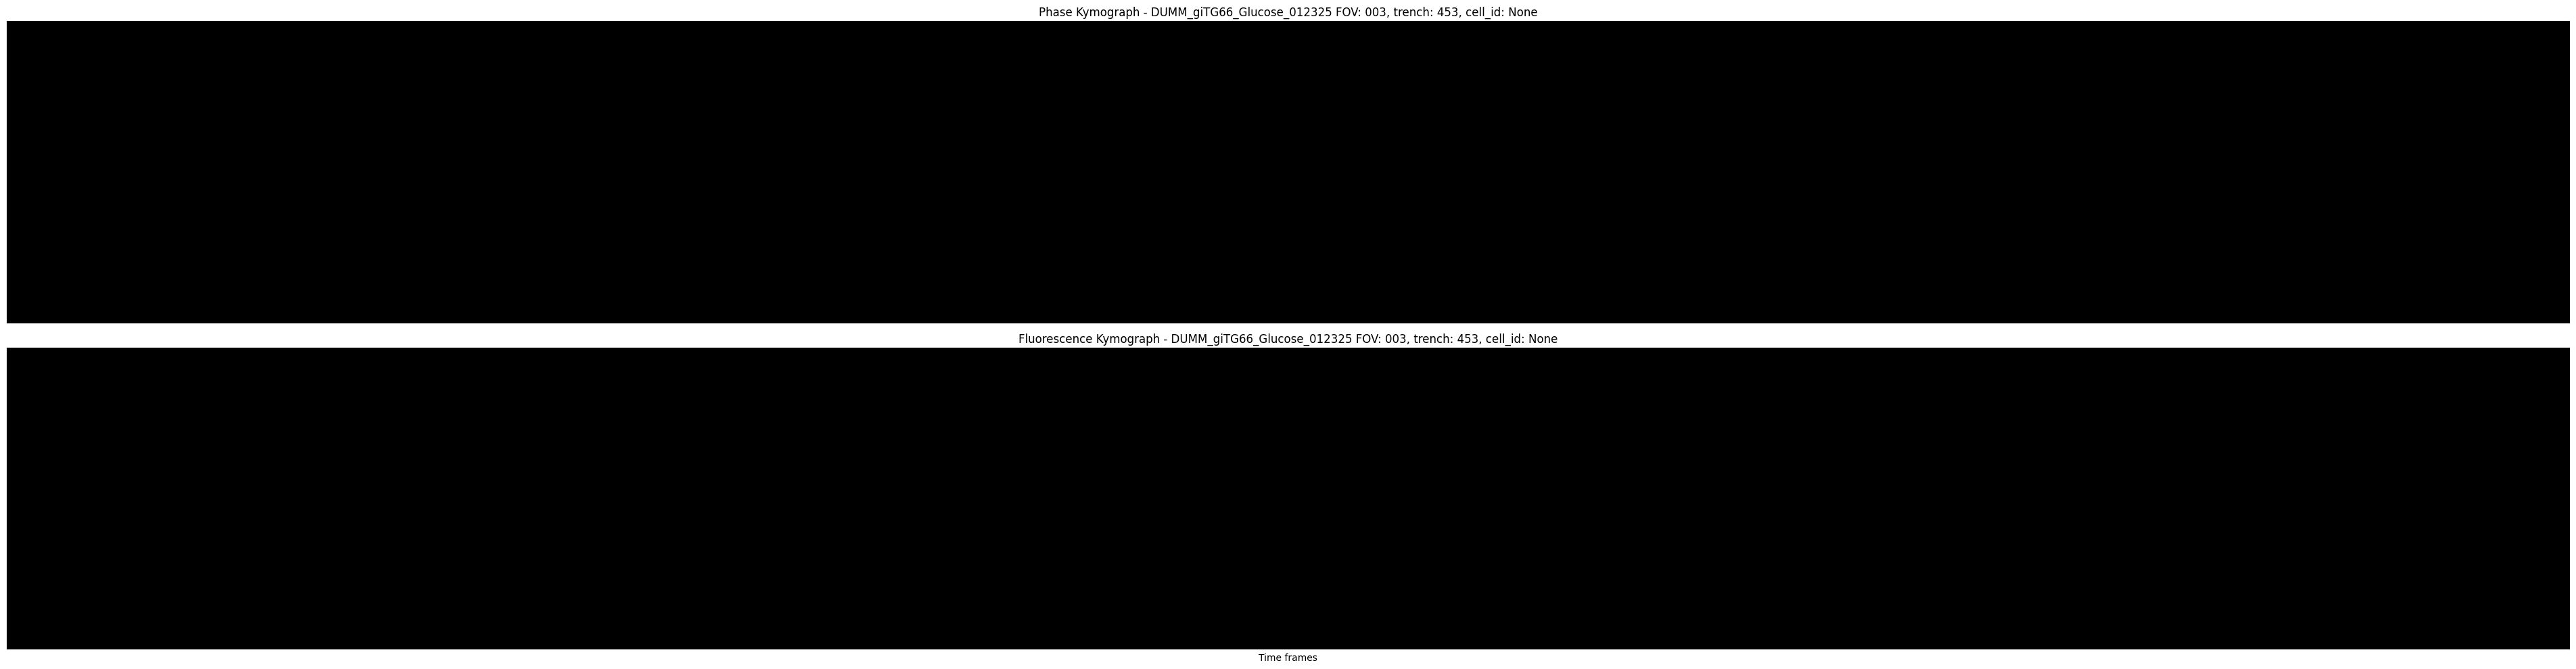

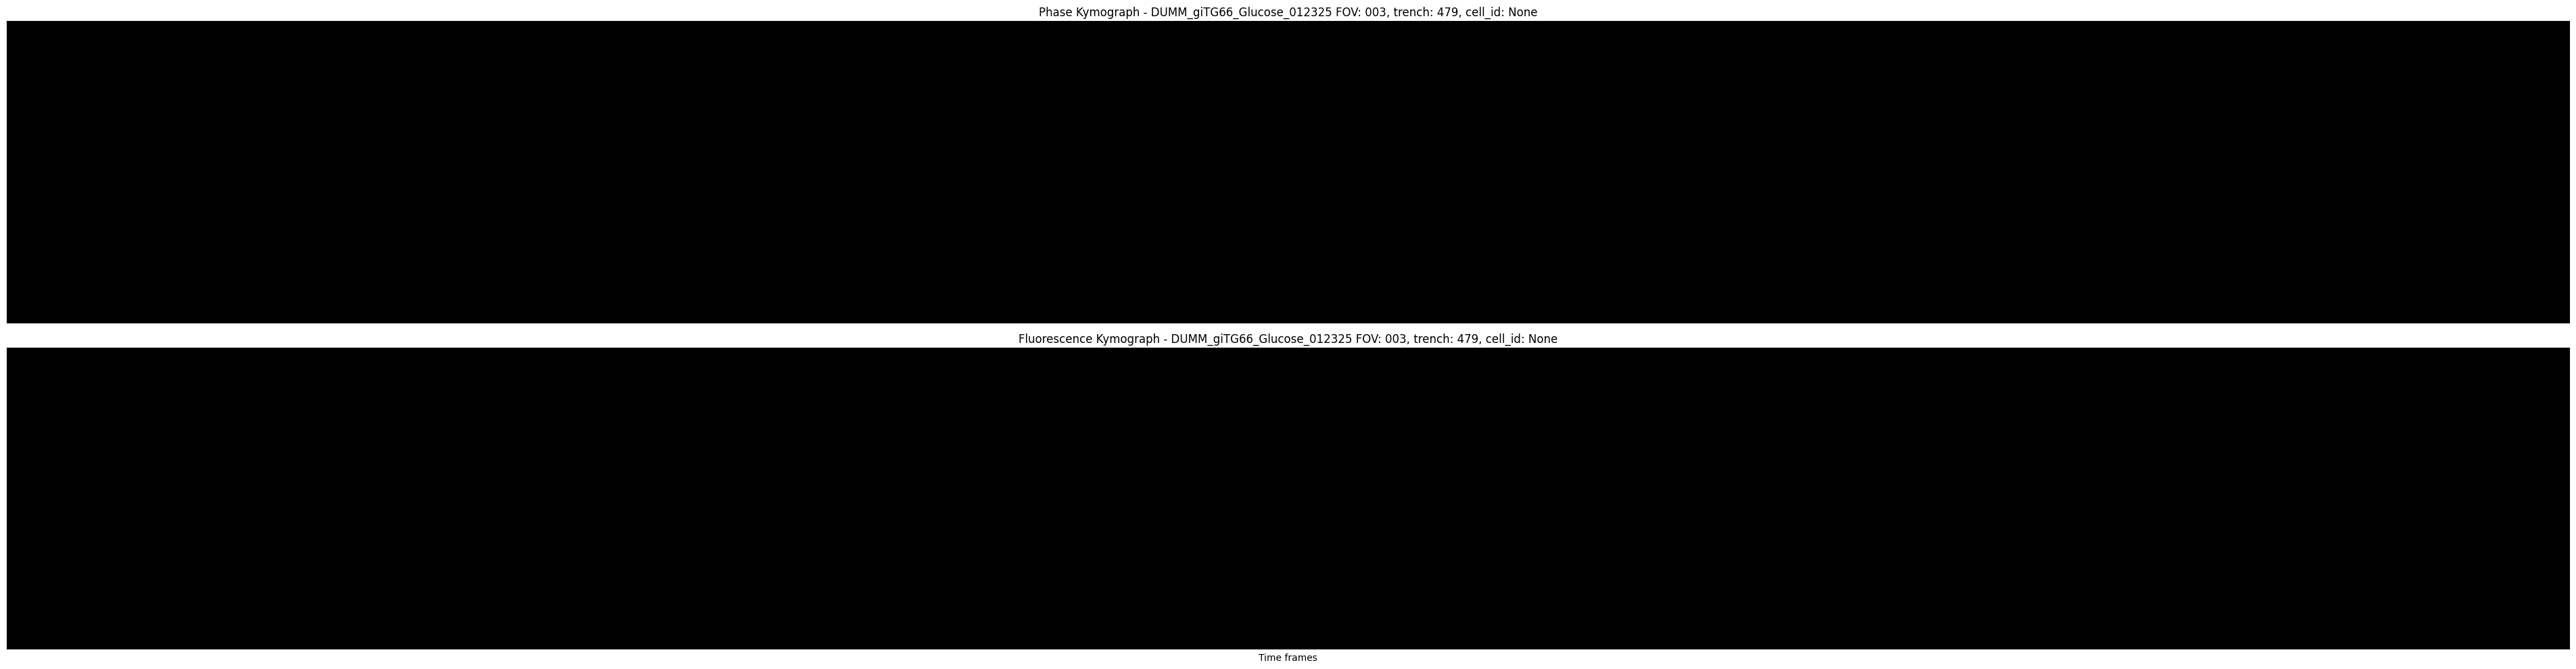

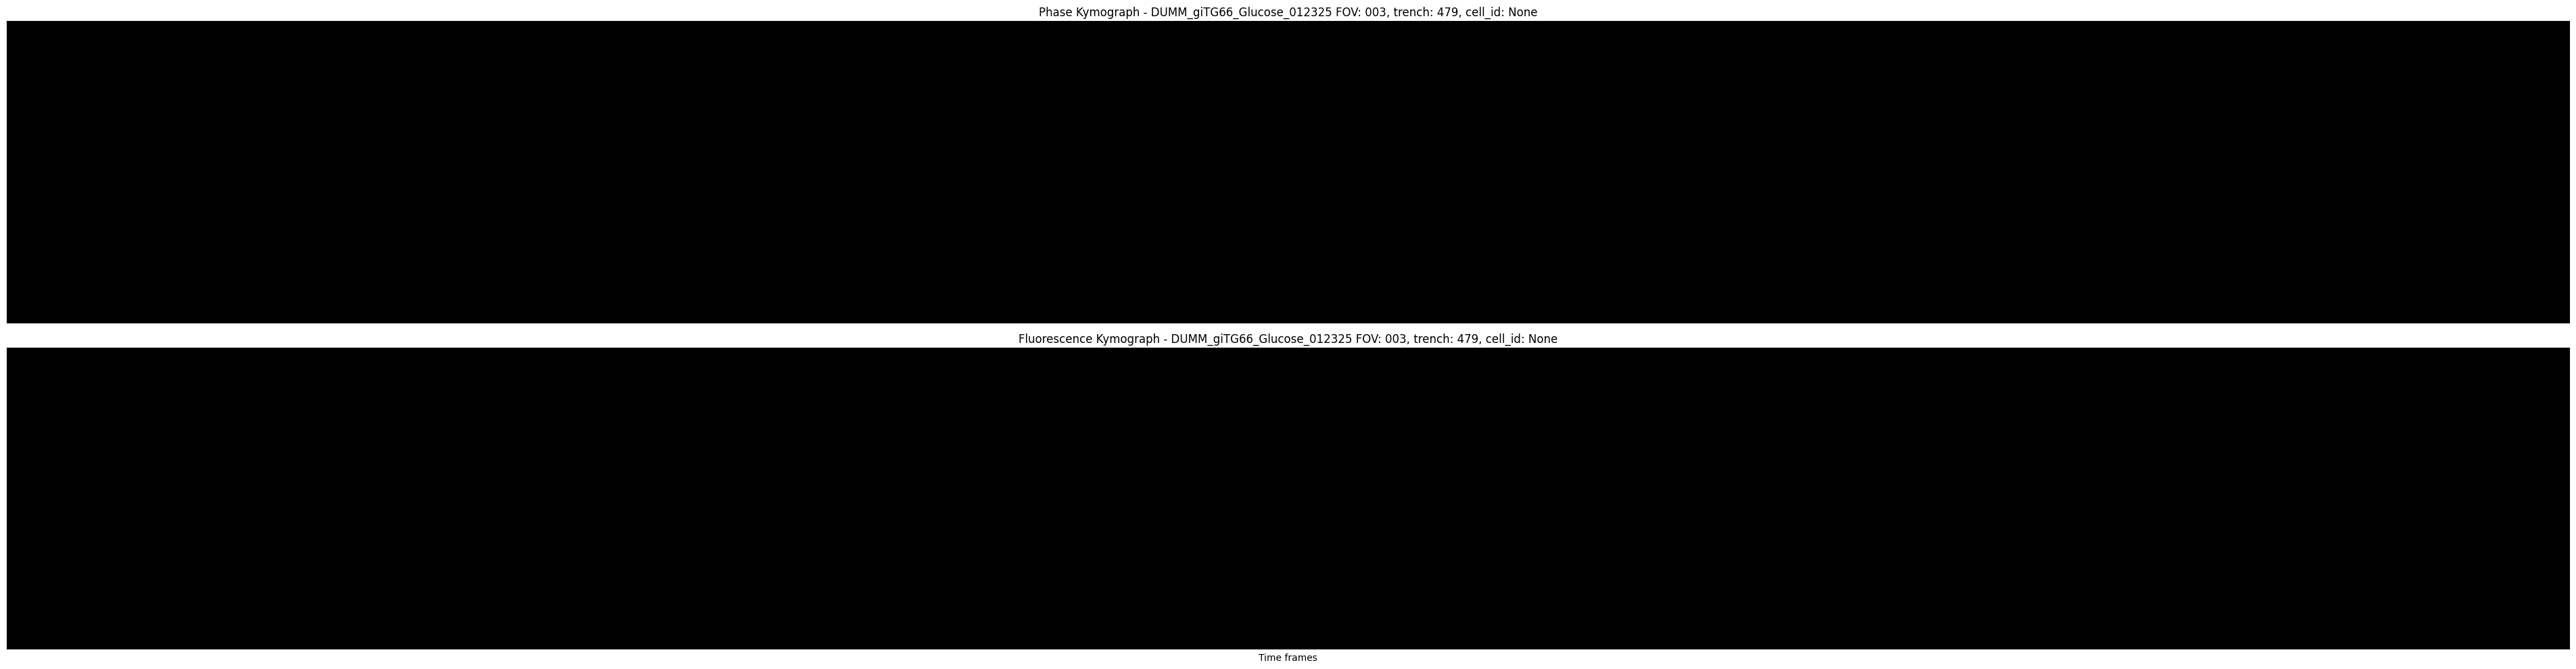

In [18]:
for cell in unique_fovs:
    exp, fov, trench = cell
    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'
    
    
    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'
    
    path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/kymographs/phase/{fov}_{trench}.tif'
    path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}//kymographs/fluor/{fov}_{trench}.tif'
    
    if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):
    
        phase_kymograph = tifffile.imread(path_to_phase_kymograph)
        fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)
        df_view = df_for_kymograph_plot[df_for_kymograph_plot['experiment_name'].isin([exp]) &
                                  df_for_kymograph_plot['FOV'].isin([fov]) &
                                  df_for_kymograph_plot['trench_id'].isin([trench]) &
                                  ~df_for_kymograph_plot['ground_truth_lineage'].isna()].copy()
        plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp, fov, trench, 
                                    None, 
                                    track_id_col='ground_truth_lineage')
    
        plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp, fov, trench, 
                                    None, 
                                    track_id_col='predicted_lineage')